# Предсказание покупательской активности пользователей интернет-магазина

## <u>Введение</u>

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов необходимо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель проекта**
Предсказать вероятность покупки в течение 90 дней.

**Задачи**
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

**Данные**
1. ```apparel-purchases``` -- история покупок
    - `client_id` -- идентификатор пользователя
    - `quantity` -- количество товаров в заказе
    - `price` -- цена товара
    - `category_ids` -- вложенные категории, к которым отнсится товар
    - `date` -- дата покупки
    - `message_id` -- идентификатор сообщения из рассылки

2. ```apparel-messages``` -- история рекламных рассылок
    - `bulk_campaign_id` -- идентификатор рекламной кампании
    - `client_id` -- идентификатор пользователя
    - `message_id` -- идентификатор сообщений
    - `event` -- тип действия
    - `channel` -- канал рассылки
    - `date` -- дата рассылки
    - `created_at` -- точное время создания сообщения
3. ```apparel-target_binary``` -- совершит ли клиент покупку в течение следующих 90 дней
    - `client_id` -- идентификатор пользователя
    - `target` -- целевой признак

4. ```full_campaign_daily_event``` -- агрегация общей базы рассылок по дням и типам событий
    - `date` -- дата
    - `bulk_campaign_id` -- идентификатор рассылки
    - `count_event*` -- общее количество каждого события `event`
    - `nunique_event*` -- количество уникальных `client_id` в каждом событии
5. ```full_campaign_daily_event_channel``` -- агрегация по дням с учетом событий и каналов рассылки
    - `date` -- дата
    - `bulk_campaign_id` -- идентификатор рассылки
    - `count_event*_channel*` -- общее количество каждого события по каналам
    - `nunique_event*_channel*` -- количество уникальных client_id по событиям и каналам

    $^{*}$ в именах колонок все типы событий `event`

## <u>Импорт библиотек</u>

### Библиотеки

In [484]:
# импорт библиотек
import pandas as pd
import numpy as np
import re
import phik
import time
from typing import List
from ast import literal_eval
from collections import Counter

# графика
import matplotlib.pyplot as plt
import seaborn as sns


# модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# выборки
from sklearn.model_selection import train_test_split

# предобработка
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler)

from sklearn.impute import SimpleImputer

# пайплайны
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# метрика
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_auc_score,
                            average_precision_score,
                            confusion_matrix,
                            precision_recall_curve,
                            make_scorer, 
                            fbeta_score)

# подбор гиперпараметров RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# анализ временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
import numpy as np

# для оценки важности признаков
import shap

# предупреждения
import warnings

### Глобальные переменные и настройки

In [485]:
# для локального выполнения -- решение проблемы с кирилицей в путях
import tempfile
tempfile.tempdir = 'C:/temp'

In [486]:
# уберем предупреждения
warnings.filterwarnings(action="ignore")

In [487]:
# ratio тестовой выборки
TEST_SIZE = 0.25

# random seed константа -- проект начат 24.11.2025
RANDOM_STATE = 241125

## <u>Вспомогательные функции</u>

**Комментарий**: ниже представлены вспомогательные функции, которые разрабатывались и затем дорабатывались в рамках предыдущих проектов.

### Функция ```dataset_info```

In [488]:
# функция вывода общей информации о датасете
def dataset_info(data):
    """
    Функция выводит информацию о датафрейме info, describe, первые и последние 5 записей
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    -----------
        None
    """
    print("Общая информация о датасете:")
    data.info();
    print("Описательная статистика датасета:")
    display(data.describe())
    print("Первые 5 записей:")
    display(data.head())
    print("Последние 5 записей:")
    display(data.tail())

### Функция ```plot_isna```

In [489]:
# функция для отображения количества пропусков в процентном соотношении от общего числа записей
def plot_isna(data):
    try:
        # вычисляем процент пропусков
        missing_data = data.isna().mean() * 100
        # фильтруем столбцы с пропусками и сортируем
        missing_data = missing_data[missing_data > 0].sort_values(ascending=True)
        
        if missing_data.empty:
            print('Пропуски в данных отсутствуют.')
            return
        
        # создаем горизонтальную столбчатую диаграмму
        fig, ax = plt.subplots(figsize=(13, 6))
        ax.barh(missing_data.index, missing_data, color='skyblue', edgecolor='black')
        
        # настраиваем подписи и заголовок
        ax.set_title('% пропусков в данных по столбцам\n(от общего количества записей в данных)', fontsize=14)
        ax.set_xlabel('Пропуски в данных, (%)', fontsize=12)
        ax.set_ylabel('Столбцы', fontsize=12)
        
        # настраиваем шрифт для меток на осях
        ax.tick_params(axis='both', labelsize=12)
        
        # добавляем сетку
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)
        
        # строим график
        plt.show()
        print("Доля пропусков по столбцам:")
        display(missing_data)
        
    except Exception as e:
        print(f'Ошибка: {e}')

### Функция ```to_snake_case```

In [490]:
def to_snake_case(name):
    """
    Преобразует CamelCase в snake_case:
    "DateCrawled" -> "date_crawled"
    
    Параметры:
    ----------
        name -- название столбца
        
    Возвращает:
    -----------
        name -- преобразованное в snake_case из CamelCase название столбца
    """
    
    # заменяем пробелы и спецсимволы на подчеркивания
    name = re.sub(r'[\s\-()]', '_', name)
    
    # вставляем _ только между camelCase (строчная -> заглавная)
    name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name)
    
    # приводим к нижнему регистру и убираем множественные подчеркивания
    name = name.lower()
    name = re.sub(r'_+', '_', name)
    
    # убираем подчеркивания в начале/конце
    return name.strip('_')

### Функция ```dataset_duplicates_info```

In [491]:
# функция для вывода общей информации о дубликатах в датафрейме
def dataset_duplicates_info(data):
    """
    Функция выводит информацию о количестве явных дубликатов в датафрейме 
    и кол-во уникальных значений в столбцах
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    ----------- 
        None
    """
    print('Размерность данных:',data.shape)
    print(data.nunique())
    print('Количество явных дубликатов:',data.duplicated().sum())

### Функция ```get_duplicated_data```

In [492]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def get_duplicated_data(data, column: str = None):
    """
    Функция возвращает данные, в которых есть явные дубликаты в столбце column
    
    Аргументы:
        data -- датафрейм
        column -- столбец, в котором ищем явные дубликаты
    
    
    Возвращает: датафрейм, который содержит записи, где в column явные дубликаты
    """
    if column is None:
        return data[data.duplicated(keep=False)]
    else:
        return data[data[column].duplicated(keep=False)]

### Функция ```remove_duplicated_data```

In [493]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def remove_duplicated_data(data, column: str = None, inplace: bool = True):
    """
    Функция удаляет явные дубликаты в данных
    
    Аргументы:
        data -- датафрейм
        inplace -- флаг на удаление данных в непосредственно в исходной таблице
    
    
    Возвращает: 
        датафрейм без дубликатов если inplace=False
        None если inplace=True
    """
    print('Размерность данных до удаления дубликатов:', data.shape)
    initial_count = data.shape[0]
    
    if inplace:
        data.drop_duplicates(subset=column, inplace=True)
        removed_count = initial_count - data.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', data.shape)
        return None
    else:
        result = data.drop_duplicates(subset=column)
        removed_count = initial_count - result.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', result.shape)
        return result

### Функция ```plot_data_analysis```

In [494]:
# вспомогательная функция для отрисовки параметров с целью их дальнейшего анализа
# функция была написана ранее в рамках предыдущих проектов, эта версия доработанная
def plot_data_analysis(
    data,
    title: str = 'Изучение параметров',
    title_box: str = 'Диаграмма размаха',
    title_hist: str = 'Распределение',
    x_label: str = 'X',
    y_label: str = 'Y',
    plot_box: bool = True,
    plot_bar: bool = False,
    x=None,
    y=None,
    bins: int = 200,
    bar_labels=None,
    discrete=False,
    figsize=None,
    color: str = 'skyblue',
    show_stats: bool = True,
    label_angle: int = 0,
    log: bool = False
):
    """
    Функция для отрисовки данных с возможностью построения:
        boxplot (диаграмма размаха)
        гистограммы или barplot (столбчатой диаграммы)
    
    Параметры:
    ----------
        data -- данные для анализа (pd.Series, pd.DataFrame или массив)
        title -- общий заголовок
        title_box -- заголовок для boxplot
        title_hist -- заголовок для гистограммы/barplot
        x_label -- подпись оси X
        y_label -- подпись оси Y
        plot_box -- строить ли boxplot (по умолчанию True)
        plot_bar -- использовать ли barplot вместо гистограммы (по умолчанию False)
        x -- данные для оси X (если нужен barplot с внешними данными)
        y -- данные для оси Y (если нужен barplot с внешними данными)
        bins -- количество бинов для гистограммы
        bar_labels -- подписи для barplot
        discrete -- флаг для дискретных данных
        figsize -- размер графика
        color -- основной цвет графиков
        show_stats -- показывать ли статистику (по умолчанию True)
    """
    # проверка и преобразование типов ходных данных
    if not isinstance(data, (pd.Series, pd.DataFrame, np.ndarray, list)):
        raise TypeError("Данные должны быть типа pd.Series, pd.DataFrame, np.ndarray или list")
    
    if isinstance(data, (pd.DataFrame, np.ndarray, list)):
        data = pd.Series(data)
    
    # настройка размера графика
    if figsize is None:
        figsize = (13, 8) if plot_box else (13, 6)
    
    # создание subplots
    if plot_box:
        fig, (ax_box, ax_main) = plt.subplots(2, 1, figsize=figsize, 
                                             gridspec_kw={'height_ratios': [1, 2]})
        # усы
        ax_box.boxplot(data, vert=False, patch_artist=True,
                      boxprops=dict(facecolor='lightblue'))
        ax_box.set_title(title_box, pad=10)
        ax_box.set_xlabel(x_label)
        ax_box.grid(axis='x', linestyle='--', alpha=0.7)
        ax_box.set_yticks([])
    else:
        fig, ax_main = plt.subplots(1, 1, figsize=figsize)
    
    # выбор типа основного графика
    if plot_bar:
        if x is None or y is None:
            if discrete:
                value_counts = data.value_counts().sort_index()
                x = value_counts.index
                y = value_counts.values
                bar_labels = x if bar_labels is None else bar_labels
            else:
                raise ValueError("Для barplot нужно указать x и y или использовать discrete=True")
        
        ax_main.bar(x=x, height=y, color=color, edgecolor='black', alpha=0.8)
        ax_main.set_title(title_hist, pad=10)
        
        # установка подписей для дискретных данных
        if bar_labels is not None:
            ax_main.set_xticks(x if discrete else np.arange(len(x)))
            ax_main.set_xticklabels(bar_labels, rotation=label_angle, ha='right')
    else:
        # гистограмма
        ax_main.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.8, log=log)
        ax_main.set_title(title_hist, pad=10)
    
    # подписи к осям и сетка
    ax_main.set_xlabel(x_label)
    ax_main.set_ylabel(y_label)
    ax_main.grid(axis='both', linestyle='--', alpha=0.5)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # вывод статистики
    if show_stats:
        display(data.describe())

### Функция ```plot_funnel```

In [495]:
def plot_funnel(
    data,
    event_column: str,
    funnel_sequence: list,
    title: str = 'Маркетинговая воронка по событиям',
    color: str = 'skyblue',
    figsize: tuple = (13, 6),
    show_percentages: bool = True,
    show_values: bool = True,
    orientation: str = 'vertical'
):
    """
    Функция для построения маркетинговой воронки из столбца с событиями
    
    Параметры:
    ----------
    data : pd.DataFrame
        Датасет с данными
    event_column : str
        Столбец с событиями (click, purchase, open, etc.)
    funnel_sequence : list
        Последовательность событий в порядке воронки
    title : str
        Заголовок графика
    color : str
        Основной цвет воронки
    figsize : tuple
        Размер графика
    show_percentages : bool
        Показывать проценты конверсии
    show_values : bool
        Показывать абсолютные значения
    orientation : str
        Ориентация воронки ('vertical' или 'horizontal')
    """
    
    # проверяем, что столбец существует
    if event_column not in data.columns:
        raise ValueError(f"Столбец '{event_column}' не найден в данных!")
    
    # считаем количество каждого события
    event_counts = data[event_column].value_counts()
    
    # собираем данные по заданной последовательности
    funnel_data = []
    for event in funnel_sequence:
        if event in event_counts.index:
            funnel_data.append(event_counts[event])
        else:
            print(f"Событие '{event}' не найдено в данных!")
            funnel_data.append(0)
    
    # считаем конверсию между этапами
    conversion_rates = []
    for i in range(1, len(funnel_data)):
        if funnel_data[i-1] > 0:
            conv_rate = (funnel_data[i] / funnel_data[i-1]) * 100
        else:
            conv_rate = 0
        conversion_rates.append(conv_rate)
    
    # создаем график
    fig, ax = plt.subplots(figsize=figsize)
    
    if orientation == 'vertical':
        # вертикальная воронка
        y_pos = np.arange(len(funnel_sequence))
        bars = ax.barh(y_pos, funnel_data, color=color, alpha=0.8, edgecolor='black')
        
        # подписи
        ax.set_yticks(y_pos)
        ax.set_yticklabels(funnel_sequence)
        ax.set_xlabel('Количество событий')
        ax.set_title(title, fontsize=14, pad=20)
        
        # добавляем значения и проценты
        for i, (bar, value) in enumerate(zip(bars, funnel_data)):
            width = bar.get_width()
            
            if value > 0:
                text_parts = []
                if show_values:
                    text_parts.append(f"{value:,}")
                if show_percentages and i > 0:
                    conv_rate = conversion_rates[i-1]
                    text_parts.append(f"{conv_rate:.1f}%")
                
                # объединяем все в одну строку над баром
                label_text = "\n".join(text_parts)
                
                ax.text(width + max(funnel_data) * 0.01, 
                       bar.get_y() + bar.get_height()/2, 
                       label_text, ha='left', va='center', fontsize=9)
    
    else:
        # горизонтальная воронка
        x_pos = np.arange(len(funnel_sequence))
        bars = ax.bar(x_pos, funnel_data, color=color, alpha=0.8, edgecolor='black')
        
        # подписи
        ax.set_xticks(x_pos)
        ax.set_xticklabels(funnel_sequence, ha='right')
        ax.set_ylabel('Количество событий')
        ax.set_title(title, fontsize=14, pad=20)
        
        # добавляем значения и проценты НАД КАЖДЫМ БАРОМ
        for i, (bar, value) in enumerate(zip(bars, funnel_data)):
            height = bar.get_height()
            
            if value > 0:
                # Формируем текст для отображения над баром
                text_parts = []
                if show_values:
                    text_parts.append(f"{value:,}")
                if show_percentages and i > 0:
                    conv_rate = conversion_rates[i-1]
                    text_parts.append(f"{conv_rate:.1f}%")
                
                # Объединяем все в одну строку над баром
                label_text = "\n".join(text_parts)
                
                # Размещаем над баром
                ax.text(bar.get_x() + bar.get_width()/2, 
                       height + max(funnel_data) * 0.02, 
                       label_text, ha='center', va='bottom', fontsize=9)
    
    ax.grid(axis='y' if orientation == 'vertical' else 'x', 
           linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # выводим статистику по воронке
    print("Статистика воронки:")
    
    for i, (stage, count) in enumerate(zip(funnel_sequence, funnel_data)):
        if i == 0:
            print(f"{stage:<25} {count:>10,}: (100.0%)")
        else:
            conv_from_previous = conversion_rates[i-1] if funnel_data[i-1] > 0 else 0
            conv_from_first = (count / funnel_data[0]) * 100 if funnel_data[0] > 0 else 0
            print(f"{stage:<25} {count:>10,}: ({conv_from_previous:3.1f}% | {conv_from_first:3.1f}%)")
    
    if funnel_data[0] > 0:
        total_conversion = (funnel_data[-1] / funnel_data[0]) * 100
        print(f"Общая конверсия: {total_conversion:.2f}%")
        print(f"Потери: {funnel_data[0] - funnel_data[-1]:,} событий")
    else:
        print("Первый этап воронки имеет 0 событий!")

### Функция ```plot_decomposition_component```

In [496]:
def plot_decomposition_component(component, title, ylabel, start_date=None, end_date=None, figsize=(13, 8)):
    """
    Построение графика компонента декомпозиции
    
    Параметры:
    ----------
    component : pd.Series
        Компонент декомпозиции (trend, seasonal, residuals)
    title : str
        Заголовок графика
    ylabel : str
        Подпись оси Y
    start_date : str, optional
        Начальная дата для отображения (формат 'YYYY-MM-DD')
    end_date : str, optional  
        Конечная дата для отображения (формат 'YYYY-MM-DD')
    figsize : tuple, optional
        Размер графика
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # делаем срез по времени, если необходимо
    if start_date is not None and end_date is not None:
        data_to_plot = component.loc[start_date:end_date]
    else:
        data_to_plot = component
    
    # рисуем
    ax.plot(data_to_plot.index, data_to_plot.values)
    
    # тип компонента
    component_name = str(component.name).lower()
    if 'seasonal' in component_name:
        title += '\nСезонная компонента'
    elif 'trend' in component_name:
        title += '\nТрендовая компонента'
    elif 'residual' in component_name:
        title += '\nОстаточная компонента'
    else:
        ylabel = 'Значение'
    
    # Заголовок и подписи осей
    ax.set_title(title)
    ax.set_xlabel('Дата и время')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()

### Функция ```plot_corr_heatmap```

In [497]:
# функция построения тепловой карты коэффициентов корреляции Пирсона
def plot_corr_heatmap(data, 
                      title: str = 'Тепловая карта корреляции', 
                      columns: List[str] = None):
    """
    Функция для построения тепловой карты коэффициентов корреляции Пирсона
    
    Параметры:
    ----------
        data -- DataFrame
    """
    plt.figure(figsize=(14, 8))
    corr_matrix = data.phik_matrix(interval_cols=columns)
    sns.heatmap(corr_matrix, 
                annot=True,  # показывать значения в ячейках
                fmt=".2f",   # формат чисел (2 знака после запятой)
                cmap='coolwarm',  # цветовая схема
                vmin=-1, vmax=1,  # диапазон значений
                linewidths=0.5)   # ширина линий между ячейками

    # заголовок
    plt.title(title)

    # вывод графика
    plt.tight_layout()
    plt.show()
    return corr_matrix

### Функция ```plot_feature_vs_target```

In [498]:
def plot_feature_vs_target(data, 
                           feature, 
                           target,
                           x_label='Признак',
                           y_label='Количество',
                           title='Распределение признака от целевого',
                           bins=30,
                           label_angle=0,
                           scatter_alpha=0.6):
    """
    Наложенные распределения фичи по бинарному таргету со scatter plot
    
    Параметры:
    ----------
    data : DataFrame
        Датафрейм с данными
    feature : str
        Название фичи для анализа
    target : str
        Название бинарного целевого признака
    x_label: str
        Подпись оси X
    y_label: str
        Подпись оси Y
    title: str
        Заголовок графика
    bins: int
        Количество бинов для гистограммы
    label_angle: int
        Угол наклона подписей шкалы по оси X
    scatter_alpha: float
        Прозрачность точек на scatter plot
    """
    
    # cоздаем фигуру с двумя субплогами
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # разделяем данные по целевому
    data_0 = data[data[target] == 0][feature]
    data_1 = data[data[target] == 1][feature]
    
    # гистограмма/bar plot
    # непрерывных фич строим гистограммы
    if data[feature].dtype in ['int64', 'float64'] and data[feature].nunique() > 10:
        ax1.hist(data_0, alpha=0.7, label='нет риска - (0)', bins=bins, color='skyblue', edgecolor='black')
        ax1.hist(data_1, alpha=0.7, label='есть риск - (1)', bins=bins, color='salmon', edgecolor='black')
        ax1.set_ylabel(y_label)
    
    # для категориальных/дискретных - bar plot
    else:
        counts_0 = data_0.value_counts().sort_index()
        counts_1 = data_1.value_counts().sort_index()
        
        x = np.arange(len(counts_0))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, counts_0, width, label='нет риска - (0)', color='skyblue', alpha=0.8, edgecolor='black')
        bars2 = ax1.bar(x + width/2, counts_1, width, label='есть риск - (1)', color='salmon', alpha=0.8, edgecolor='black')
        
        # добавляем подписи только если не слишком много баров
        if len(counts_0) <= 20:
            ax1.bar_label(bars1, fmt='%.0f', padding=3, fontsize=8)
            ax1.bar_label(bars2, fmt='%.0f', padding=3, fontsize=8)
        
        try:
            xtick_labels = [f'{float(val):.2f}' for val in counts_0.index]
        except (ValueError, TypeError):
            xtick_labels = [str(val) for val in counts_0.index]
        ax1.set_xticks(x)
        ax1.set_xticklabels(xtick_labels, rotation=label_angle)
        ax1.set_ylabel(y_label)
    
    ax1.set_xlabel(x_label)
    ax1.set_title(f'{title}\n(Распределение)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # scatter plot
    if data[feature].dtype in ['int64', 'float64']:
        jitter = np.random.normal(0, 0.02, size=len(data))
        y_jitter = data[target] + jitter
        
        scatter = ax2.scatter(data[feature], y_jitter, 
                             c=data[target], alpha=scatter_alpha, 
                             cmap='coolwarm', edgecolors='black', linewidth=0.5)
        
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Целевая переменная')
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['Нет риска (0)', 'Есть риск (1)'])
        ax2.set_title(f'{title}\n(Scatter Plot)')
        ax2.grid(alpha=0.3)
        
        # фиганем линию тренда если признак числовой
        if data[feature].nunique() > 10:
            z = np.polyfit(data[feature], data[target], 1)
            p = np.poly1d(z)
            x_range = np.linspace(data[feature].min(), data[feature].max(), 100)
            ax2.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2, 
                    label=f'Тренд (наклон: {z[0]:.3f})')
            ax2.legend()
    
    else:
        # категориальных признаков - boxplot вместо scatter
        data_boxplot = data.copy()
        data_boxplot[target] = data_boxplot[target].astype(str)
        sns.boxplot(data=data_boxplot, x=feature, y=target, ax=ax2, palette='coolwarm')
        ax2.set_title(f'{title}\n(Box Plot)')
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Целевая переменная')
    
    plt.tight_layout()
    plt.show()
    
    # статистика
    print(f"Статистика по {feature}:")
    print(f"Уникальных значений: {data[feature].nunique()}")
    print(f"Тип данных: {data[feature].dtype}")
    
    # средние значения только для числовых фич
    if data[feature].dtype in ['int64', 'float64']:
        print(f"\nСредние значения:")
        print(f"Без риска: {data_0.mean():.3f}")
        print(f"С риском: {data_1.mean():.3f}")

        # корреляция
        correlation = data[feature].corr(data[target])
        print(f"Корреляция с целевой: {correlation:.3f}")
                
        # разница средних для количественных
        if data[feature].nunique() > 10:
            mean_diff = data_1.mean() - data_0.mean()
            print(f"Разница средних (риск - нет риска): {mean_diff:.3f}")
            print(f"Относительная разница: {mean_diff/data_0.mean():.2%}")


    # доли риска для категориальных
    if data[feature].nunique() <= 10:
        risk_ratios = data.groupby(feature)[target].mean()
        print(f"\nДоли риска по категориям {feature}:")
        for category, ratio in risk_ratios.items():
            print(f"  {category}: {ratio:.1%}")

### Функция ```corr_analysis```

In [499]:
def corr_analysis(corr_matrix, 
                  target_feature, 
                  features=None, 
                  min_abs_corr=0.1):
    """
    Анализирует корреляции целевого признака с другими признаками и сортирует их по убыванию.
    
    Параметры:
    ----------
    corr_matrix : DataFrame
        Матрица корреляции (phik-матрица или обычная корреляционная матрица)
    target_feature : str
        Название целевого признака для анализа
    features : list, optional
        Список признаков для анализа (если None, берутся все из матрицы)
    min_abs_corr : float, optional
        Минимальная абсолютная корреляция для включения в результат (по умолчанию 0.1)
        
    Возвращает:
    -----------
    DataFrame
        Таблица с признаками, отсортированными по убыванию абсолютной корреляции с целевым признаком,
        с указанием силы связи по шкале Чеддока
    """
    # если не указан список признаков, берем все из матрицы (исключая целевой)
    if features is None:
        features = [col for col in corr_matrix.columns if col != target_feature]
    
    # собираем корреляции с целевым признаком
    correlations = []
    
    for feature in features:
        if feature == target_feature:
            continue
        
        corr = corr_matrix.loc[target_feature, feature]
        abs_corr = abs(corr)
        
        # реализуем шкалу Чеддока (согласно 11 спринту - 3 тема - 9 урок)
        if abs_corr >= 0.9:
            strength = 'Весьма высокая'
        elif abs_corr >= 0.7:
            strength = 'Высокая'
        elif abs_corr >= 0.5:
            strength = 'Заметная'
        elif abs_corr >= 0.3:
            strength = 'Умеренная'
        elif abs_corr >= 0.1:
            strength = 'Слабая'
        elif abs_corr > min_abs_corr and abs_corr < 0.1:
            strength = 'Очень слабая'
        elif abs_corr < min_abs_corr:
            strength = 'Отсутствует'
        
        # определяем направление связи
        direction = 'положительная' if corr > 0 else 'отрицательная'
        
        correlations.append({
            'Признак': feature,
            'Корреляция': corr,
            'Абс. корреляция': abs_corr,
            'Сила связи': strength,
            'Направление': direction
        })
    
    # создаем DataFrame и сортируем по убыванию абсолютной корреляции
    if not correlations:
        return pd.DataFrame()  # возвращаем пустой DataFrame если нет корреляций
    
    result_df = pd.DataFrame(correlations).sort_values(
        by='Абс. корреляция', ascending=False
    ).reset_index(drop=True)
    
    # вывод корреляции для удобства чтения
    result_df['Корреляция'] = result_df['Корреляция'].apply(lambda x: f"{x:.3f}")
    
    return result_df[['Признак', 'Корреляция', 'Сила связи', 'Направление']]

### Функция ```evaluate_model```

In [500]:
def evaluate_model(model, 
                   params, 
                   model_name, 
                   X_train, 
                   y_train,
                   preprocessor_ohe,
                   preprocessor_ordinal,
                   random_state=42,
                   refit_metric='roc_auc',
                   cv=3,
                   n_iter=5):
    """
    Функция для оценки моделей бинарной классификации
    
    Параметры:
    ----------
    model: модель
    params: гиперпараметры для перебора
    model_name: название модели
    X_train: входные признаки обучающей выборки
    y_train: целевой признак обучающей выборки
    preprocessor: пайплайн для предобработки
    random_state: зерно для рандома
    refit_metric: метрика для выбора лучшей модели 
                 ('roc_auc', 'recall', 'precision', 'f1', 'average_precision', 'f2')
    cv: количество cv фолдов
    n_iter: количество итераций
    
    Возвращает:
    -----------
    Словарь c параметрами:  
        - 'model_name': название модели
        - 'best_model': лучшая модель после подбора гиперпараметров
        - 'best_params': лучшие гиперпараметры
        - 'accuracy_cv': Accuracy на кросс-валидации
        - 'precision_cv': Precision на кросс-валидации
        - 'recall_cv': Recall на кросс-валидации
        - 'roc_auc_cv': ROC-AUC на кросс-валидации
        - 'average_precision_cv': Average Precision на кросс-валидации
        - 'f1_cv': F1-score на кросс-валидации
        - 'f2_cv': F2-score на кросс-валидации
        - 'params_time': время подбора гиперпараметров
        - 'train_time': среднее время обучения лучшей модели (из cv_results_df)
        - 'predict_time': среднее время предсказания лучшей модели (из cv_results_df)
        - 'cv_results_df': таблица с полной информацией из cv_results_
    """
    
    linear_models = ['LogisticRegression', 'KNeighborsClassifier']
    
    is_linear = any(linear_model in model_name for linear_model in linear_models)
    
    if 'Dummy' in model_name:
        preprocessor = preprocessor_ordinal
    elif any(linear_model in model_name for linear_model in linear_models):
        preprocessor = preprocessor_ohe
        print(f"Для линейной модели {model_name} используется OneHotEncoder")
    else:
        preprocessor = preprocessor_ordinal
        print(f"Для нелинейной модели {model_name} используется OrdinalEncoder")
    
    pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    # метрики для классификации
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall', 
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'f2': f2_scorer,
        'average_precision': 'average_precision'
    }
    
    # Проверяем что refit_metric есть в scoring
    if refit_metric not in scoring:
        raise ValueError(f"refit_metric должен быть одним из: {list(scoring.keys())}")
    
    # замер времени подбора параметров
    search = RandomizedSearchCV(pipeline, 
                                params, 
                                n_iter=n_iter, 
                                cv=cv,
                                scoring=scoring,
                                refit=refit_metric,
                                return_train_score=True,
                                random_state=random_state,
                                n_jobs=-1)
    
    try:
        # замер времени подбора параметров
        start_time = time.time()
        search.fit(X_train, y_train)
        params_time = time.time() - start_time
    except Exception as e:
        print(f"Ошибка при подборе гиперпараметров для {model_name}: {e}")
        return None

    # берем cv_results_
    cv_results_df = pd.DataFrame(search.cv_results_)
    
    best_index = search.best_index_
    best_train_time = cv_results_df.loc[best_index, 'mean_fit_time']
    best_predict_time = cv_results_df.loc[best_index, 'mean_score_time']
    
    # берем лучшие метрики
    best_accuracy_cv = cv_results_df.loc[best_index, 'mean_test_accuracy']
    best_precision_cv = cv_results_df.loc[best_index, 'mean_test_precision']
    best_recall_cv = cv_results_df.loc[best_index, 'mean_test_recall']
    best_roc_auc_cv = cv_results_df.loc[best_index, 'mean_test_roc_auc']
    best_f1_cv = cv_results_df.loc[best_index, 'mean_test_f1']
    best_f2_cv = cv_results_df.loc[best_index, 'mean_test_f2']
    best_average_precision_cv = cv_results_df.loc[best_index, 'mean_test_average_precision']

    print(f"Модель: {model_name}")
    print(f"Лучшие параметры: {search.best_params_}")
    print(f"Время подбора параметров: {params_time:.3f} с.")
    print(f"Время обучения лучшей модели: {best_train_time:.3f} с.")
    print(f"Время предсказания лучшей модели: {best_predict_time:.3f} с.")
    print(f"Accuracy на кросс-валидации: {best_accuracy_cv:.4f}")
    print(f"Precision на кросс-валидации: {best_precision_cv:.4f}")
    print(f"Recall на кросс-валидации: {best_recall_cv:.4f}")
    print(f"ROC-AUC на кросс-валидации: {best_roc_auc_cv:.4f}")
    print(f"F1-score на кросс-валидации: {best_f1_cv:.4f}")
    print(f"F2-score на кросс-валидации: {best_f2_cv:.4f}")
    print(f"Average Precision на кросс-валидации: {best_average_precision_cv:.4f}\n")

    return {
        'model_name': model_name,
        'best_model': search.best_estimator_,
        'best_params': search.best_params_,
        'accuracy_cv': best_accuracy_cv,
        'precision_cv': best_precision_cv,
        'recall_cv': best_recall_cv,
        'roc_auc_cv': best_roc_auc_cv,
        'average_precision_cv': best_average_precision_cv,
        'f1_cv': best_f1_cv,
        'f2_cv': best_f2_cv,
        'params_time': params_time,
        'train_time': best_train_time,
        'predict_time': best_predict_time,
        'cv_results_df': cv_results_df
    }

### Функция ```plot_confusion_matrix```

In [501]:
def plot_confusion_matrix(conf_matrix, 
                          title='Матрица ошибок',
                          labels=['нет', 'да']
                         ):
    """
    Визуализирует матрицу ошибок (confusion matrix)
    
    Параметры:
    ----------
    conf_matrix : array-like
        Матрица ошибок в формате [[TN, FP], [FN, TP]]
    title : str, optional
        Заголовок графика (по умолчанию 'Матрица ошибок')
    labels : list, optional
        Подписи классов [negative, positive] (по умолчанию ['нет', 'да'])
    """
    plt.figure(figsize=(13, 6))
    ax = sns.heatmap(conf_matrix, 
                     annot=True, 
                     fmt='d', 
                     cmap='icefire',
                     xticklabels=labels,
                     yticklabels=labels)
    
    ax.set_title(title, pad=20, fontsize=12)
    ax.set_xlabel('Предсказанное значение', fontsize=10)
    ax.set_ylabel('Реальное значение', fontsize=10)
    
    # добавляем аннотации для лучшей читаемости
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[0])):
            text = ax.texts[i * len(conf_matrix[0]) + j]
            text.set_fontsize(12)
            text.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()

    # дополнительная текстовая интерпретация
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"Интерпретация:")
    print(f"  Правильно предсказано 'нет' (True Negative): {tn}")
    print(f"  Ложно предсказано 'да' (False Positive): {fp}")
    print(f"  Ложно предсказано 'нет' (False Negative): {fn}")
    print(f"  Правильно предсказано 'да' (True Positive): {tp}")

## <u>Загрузка данных и изучение общей информации</u>

**Комментарий**: выполним загрузку данных и изучим общую информацию о них.

### Загрузка данных

**Комментарий**: выполним загрузку данных.

In [502]:
# выполняем чтение данных
path_to_data = 'data\\'
try:
    app_purchases = pd.read_csv(f'{path_to_data}apparel-purchases.csv', parse_dates=[4])
    app_messages = pd.read_csv(f'{path_to_data}apparel-messages.csv', parse_dates=[5, 6])
    app_target = pd.read_csv(f'{path_to_data}apparel-target_binary.csv')
    fc_daily = pd.read_csv(f'{path_to_data}full_campaign_daily_event.csv', parse_dates=[0])
    fc_daily_channel = pd.read_csv(f'{path_to_data}full_campaign_daily_event_channel.csv', parse_dates=[0])
except:
    print("Ошибка чтения данных!")

**Промежуточный вывод**: данные успешно загружены

### Изучение общей информации

**Комментарий**: изучим общую информацию каждой таблицы.

#### Таблица ```app_purchases```

**Комментарий**: выведем общую информацию о данных ```app_purchases``` -- история покупок.

In [503]:
# выведем информацию о данных
dataset_info(app_purchases)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
Описательная статистика датасета:


,client_id,quantity,price,date
count,2.022080e+05,202208.000000,202208.000000,202208
mean,1.515916e+18,1.006483,1193.301516,2023-03-17 02:49:35.739832064
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00
25%,1.515916e+18,1.000000,352.000000,2022-11-12 00:00:00
50%,1.515916e+18,1.000000,987.000000,2023-04-12 00:00:00
75%,1.515916e+18,1.000000,1699.000000,2023-07-03 00:00:00
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00
std,1.459458e+08,0.184384,1342.252664,NaN


Первые 5 записей:


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Последние 5 записей:


,client_id,quantity,price,category_ids,date,message_id
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490
202207,1515915626010443624,1,999.0,"['4', '28', '62', '656']",2024-02-16,1515915625488468007-14668-65cf5234b1295


**Промежуточный вывод**: с данными всё в порядке.

#### Таблица ```app_messages```

**Комментарий**: выведем общую информацию о данных ```app_messages``` -- история рекламных рассылок.

In [504]:
# выведем информацию о данных
dataset_info(app_messages)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB
Описательная статистика датасета:


,bulk_campaign_id,client_id,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798
mean,1.160459e+04,1.515916e+18,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,5.480000e+02,1.515916e+18,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,8.746000e+03,1.515916e+18,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,1.351600e+04,1.515916e+18,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,1.415800e+04,1.515916e+18,2023-11-21 00:00:00,2023-11-21 18:13:05
max,1.465700e+04,1.515916e+18,2024-02-15 00:00:00,2024-02-15 23:58:40
std,3.259211e+03,1.329704e+08,NaN,NaN


Первые 5 записей:


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Последние 5 записей:


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40
12739797,14641,1515915625477497874,1515915625477497874-14641-65cb249172d68,open,email,2024-02-15,2024-02-15 23:58:40


**Промежуточный вывод**: необходимо будет проверить данные на пропуски, привести дату к корректному типу.

#### Таблица ```app_target```

**Комментарий**: выведем общую информацию о данных ```app_target``` -- целевой признак -- совершит ли клиент покупку в течение следующих 90 дней.

In [505]:
# выведем информацию о данных
dataset_info(app_target)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
Описательная статистика датасета:


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


Первые 5 записей:


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Последние 5 записей:


,client_id,target
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0
49848,1515915626010443624,0


**Промежуточный вывод**: с данными всё в порядке.

#### Таблица ```fc_daily```

**Комментарий**: выведем общую информацию о данных ```fc_daily``` -- агрегация общей базы рассылок по дням и типам событий.

In [506]:
# выведем информацию о данных
dataset_info(fc_daily)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,2023-05-11 18:39:38.320312576,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
min,2022-05-19 00:00:00,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-11-06 00:00:00,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-04-01 00:00:00,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-12-25 00:00:00,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2024-05-15 00:00:00,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000
std,NaN,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762


Первые 5 записей:


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Последние 5 записей:


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
131067,2024-05-15,15067,0,0,0,0,0,0,0,0,...,0,0,0,0,0,15,0,0,0,0
131068,2024-05-15,15096,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0,0,0,0
131069,2024-05-15,15102,0,0,0,0,0,0,0,0,...,0,0,0,0,0,12,0,0,0,0
131070,2024-05-15,15116,0,0,0,0,0,0,0,1,...,0,0,0,0,1,32,0,0,0,0
131071,2024-05-15,15148,0,0,0,0,0,0,3,6,...,0,0,0,3,6,556,0,0,0,0


**Промежуточный вывод**: с данными всё в порядке.

#### Таблица ```fc_daily_channel```

**Комментарий**: выведем общую информацию о данных ```fc_daily_channel``` -- агрегация по дням с учетом событий и каналов рассылки.

In [507]:
# выведем информацию о данных
dataset_info(fc_daily_channel)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscri

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,2023-05-11 18:39:38.320312576,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
min,2022-05-19 00:00:00,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-11-06 00:00:00,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-04-01 00:00:00,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-12-25 00:00:00,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-05-15 00:00:00,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000
std,NaN,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762


Первые 5 записей:


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Последние 5 записей:


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
131067,2024-05-15,15067,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131068,2024-05-15,15096,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131069,2024-05-15,15102,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131070,2024-05-15,15116,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
131071,2024-05-15,15148,0,0,0,0,0,0,3,6,...,0,0,0,0,0,0,0,0,0,0


**Промежуточный вывод**: с данными всё в порядке.

### Промежуточный вывод

Данные успешно загружены, изучена общая информация:
- Во всех данных отсутствуют пропуски, хотя для ```app_messages``` необходимо провести дополнительную проверку из-за размера датасета.

## <u>Предобработка данных</u>

**Комментарий**: выполним предварительную обработку данных: проведем переименование столбцов, проверим данные на наличие пропусков и явных дубликатов, а также проверим корректность типов данных в столбцах таблиц.

### Пропуски в данных

**Комментарий**: проверим на пропуски данные ```app_messages``` -- данные об истории рекламных рассылок.

In [508]:
# проверим наличие пропусков
plot_isna(app_messages)

Пропуски в данных отсутствуют.


**Комментарий**: в остальных данных пропуски отсутствуют, что наблюдается при изучении общей информации о данных разделом выше.

**Промежуточный вывод**: пропуски в данных не обнаружены.

### Дубликаты в данных

**Комментарий**: проверим данные на наличие явных дубликатов.

In [509]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_messages)

Размерность данных: (12739798, 7)
bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64
Количество явных дубликатов: 48610


**Комментарий**: обнаружено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных. Предлагается их удалить, но для начала бегло просмотрим.

In [510]:
# получим явные дубликаты
duplicates = get_duplicated_data(app_messages)

In [511]:
# отсортируем дубликаты по client_id для удобства анализа
duplicates = duplicates.sort_values('client_id')

In [512]:
# выведем первые 5 явных дубликатов
duplicates.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
5109179,12566,1515915625468061003,1515915625468061003-12566-646330138e845,click,email,2023-05-16,2023-05-16 13:29:21
5109180,12566,1515915625468061003,1515915625468061003-12566-646330138e845,click,email,2023-05-16,2023-05-16 13:29:21
5656176,13332,1515915625468061100,1515915625468061100-13332-64848a3038e23,open,mobile_push,2023-06-10,2023-06-10 14:36:00
5609618,13324,1515915625468061100,1515915625468061100-13324-648403889887c,open,mobile_push,2023-06-10,2023-06-10 05:10:37
5609617,13324,1515915625468061100,1515915625468061100-13324-648403889887c,open,mobile_push,2023-06-10,2023-06-10 05:10:37


In [513]:
# выведем последние 5 явных дубликатов
duplicates.tail()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
12588291,14631,1515915626009796859,1515915626009796859-14631-65c9c261352f2,click,mobile_push,2024-02-12,2024-02-12 14:43:31
12469872,14618,1515915626009802894,1515915626009802894-14618-65c4cec6a2db8,click,mobile_push,2024-02-09,2024-02-09 05:36:42
12469871,14618,1515915626009802894,1515915626009802894-14618-65c4cec6a2db8,click,mobile_push,2024-02-09,2024-02-09 05:36:42
12738205,14653,1515915626010221592,1515915626010221592-14653-65cdc49de879f,click,mobile_push,2024-02-15,2024-02-15 09:34:58
12738204,14653,1515915626010221592,1515915626010221592-14653-65cdc49de879f,click,mobile_push,2024-02-15,2024-02-15 09:34:58


**Комментарий**: удалим явные дубликаты.

In [514]:
# удалим явные дубликаты
remove_duplicated_data(app_messages)

Размерность данных до удаления дубликатов: (12739798, 7)
Удалено дубликатов: 48610
Размерность данных после удаления дубликатов: (12691188, 7)


In [515]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_purchases)

Размерность данных: (202208, 6)
client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64
Количество явных дубликатов: 73020


**Комментарий**: обнаружено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных. Предлагается их удалить, но для начала бегло просмотрим.

In [516]:
# получим явные дубликаты
duplicates = get_duplicated_data(app_purchases)

In [517]:
# отсортируем дубликаты по client_id для удобства анализа
duplicates = duplicates.sort_values('client_id')

In [518]:
# выведем первые 5 явных дубликатов
duplicates.head()

,client_id,quantity,price,category_ids,date,message_id
3696,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
3698,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
3695,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196
3699,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196
81793,1515915625468061003,1,2100.0,"['4', '28', '249', '615']",2023-01-04,1515915625468061003-9148-63b54b04855a4


In [519]:
# выведем последние 5 явных дубликатов
duplicates.tail()

,client_id,quantity,price,category_ids,date,message_id
202200,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
201563,1515915626010266132,1,909.0,"['4', '27', '278', '470']",2024-02-14,1515915625999374481-14623-65c5c5acbad8c
201564,1515915626010266132,1,909.0,"['4', '27', '278', '470']",2024-02-14,1515915625999374481-14623-65c5c5acbad8c
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d


**Комментарий**: удалим явные дубликаты.

In [520]:
# удалим явные дубликаты
remove_duplicated_data(app_purchases)

Размерность данных до удаления дубликатов: (202208, 6)
Удалено дубликатов: 73020
Размерность данных после удаления дубликатов: (129188, 6)


In [521]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_target)

Размерность данных: (49849, 2)
client_id    49849
target           2
dtype: int64
Количество явных дубликатов: 0


In [522]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(fc_daily)

Размерность данных: (131072, 24)
date                    727
bulk_campaign_id       3181
count_click            2284
count_complain          249
count_hard_bounce      1283
count_open             5321
count_purchase          192
count_send             2821
count_soft_bounce       741
count_subscribe          85
count_unsubscribe       697
nunique_click          2118
nunique_complain        238
nunique_hard_bounce    1277
nunique_open           5287
nunique_purchase        177
nunique_send           2822
nunique_soft_bounce     738
nunique_subscribe        79
nunique_unsubscribe     670
count_hbq_spam          104
nunique_hbq_spam        105
count_close               2
nunique_close             2
dtype: int64
Количество явных дубликатов: 0


In [523]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(fc_daily_channel)

Размерность данных: (131072, 36)
date                                727
bulk_campaign_id                   3181
count_click_email                  1375
count_click_mobile_push            1560
count_open_email                   3785
count_open_mobile_push             2883
count_purchase_email                172
count_purchase_mobile_push          113
count_soft_bounce_email             497
count_subscribe_email                85
count_unsubscribe_email             697
nunique_click_email                1249
nunique_click_mobile_push          1460
nunique_open_email                 3740
nunique_open_mobile_push           2887
nunique_purchase_email              156
nunique_purchase_mobile_push         99
nunique_soft_bounce_email           493
nunique_subscribe_email              79
nunique_unsubscribe_email           670
count_hard_bounce_mobile_push      1035
count_send_mobile_push             2365
nunique_hard_bounce_mobile_push    1029
nunique_send_mobile_push           2365
count_h

**Промежуточный вывод**:
- В данных ```app_messages``` обнаружено и удалено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных;
- В ```app_purchases``` обнаружено и удалено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных.

### Промежуточный вывод

Проведена предварительная обработка данных:
- Пропуски в данных нигде не обнаружены;
- В данных ```app_messages```, ```app_purchases```, ```fc_daily```, ```fc_daily_channel``` даты приведены к корректному типу;
- В данных ```app_messages``` и ```app_purchases``` обнаружены и удалены явные дубликаты:
    - В данных ```app_messages``` обнаружено и удалено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных;
    - В ```app_purchases``` обнаружено и удалено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных.

## <u>Исследовательский анализ данных</u>

**Комментарий**: проведем теперь исследовательский анализ данных.

### Таблица ```app_purchases```

**Комментарий**: исследуем таблицу ```app_purchases``` -- история покупок.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [524]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_purchases['client_id'].nunique()}')

Уникальных клиентов: 49849


**Промежуточный вывод**: в данных содержится **49849** уникальных клиентов.

#### Признак ```quantity```

**Комментарий**: рассмотрим подробнее признак ```quantity``` -- количество единиц товара.

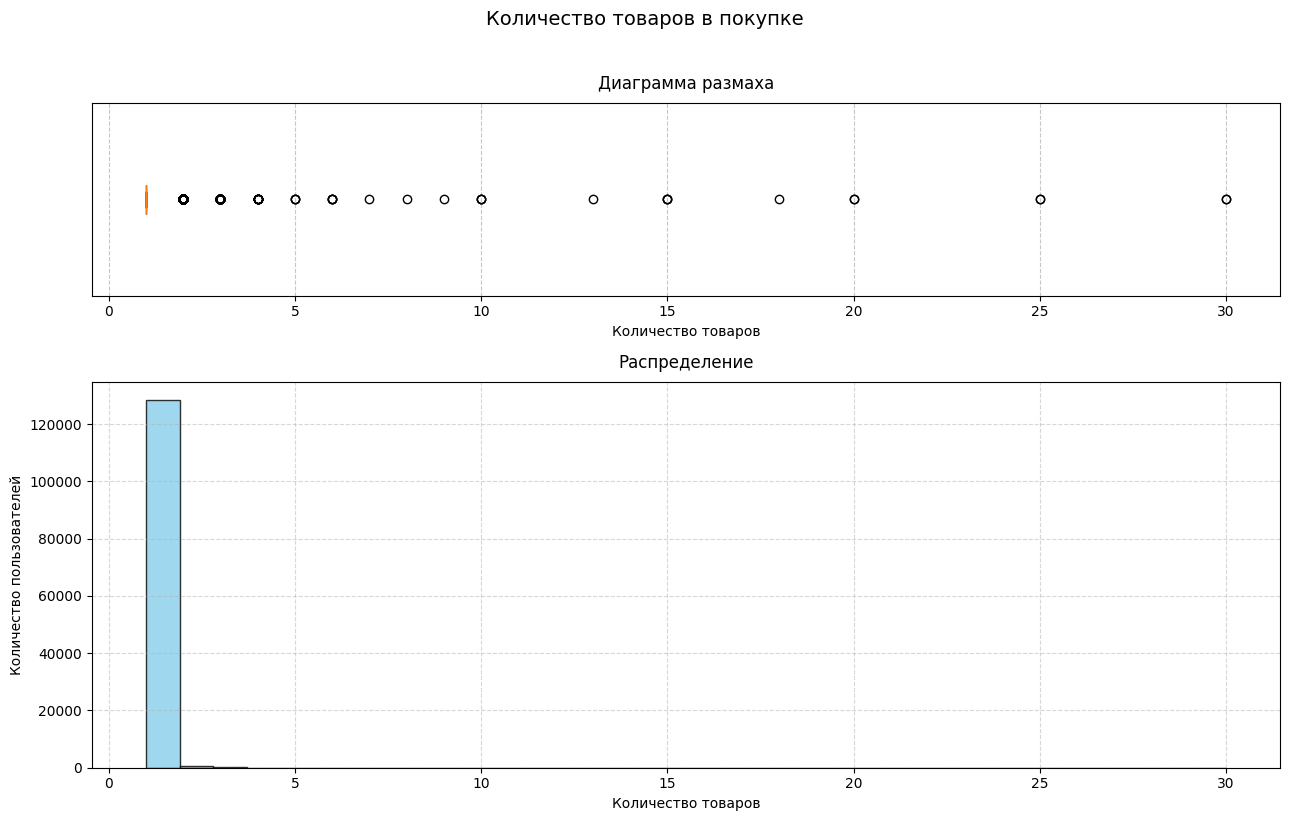

count    129188.000000
mean          1.009420
std           0.220332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

In [525]:
# выведем график распределения
plot_data_analysis(app_purchases['quantity'],
                   title = 'Количество товаров в покупке',
                   x_label = 'Количество товаров',
                   y_label = 'Количество пользователей',
                   plot_box = True,
                   discrete = False,
                   bins=32
                   )

**Промежуточный вывод**:

#### Признак ```price```

**Комментарий**: рассмотрим подробнее признак ```price``` -- цена товара.

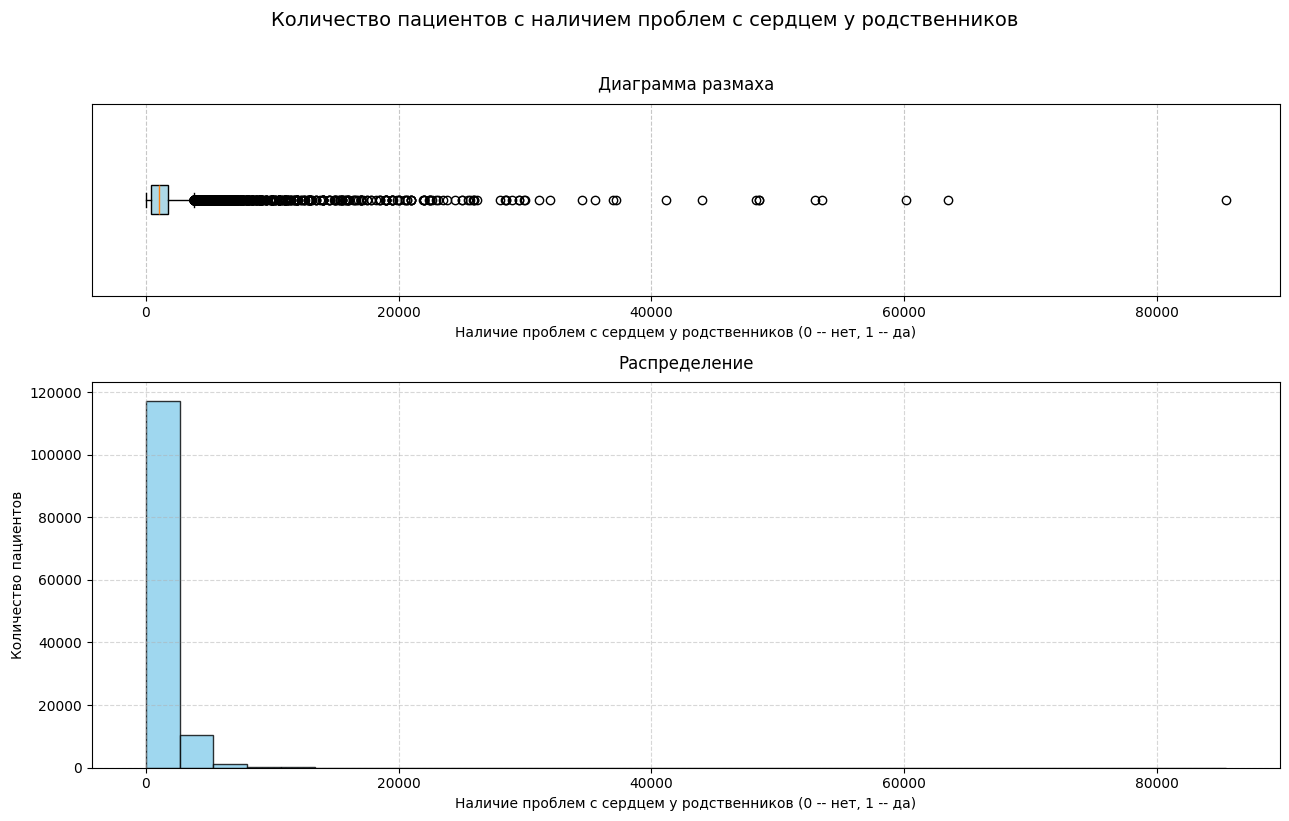

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

In [526]:
# выведем график распределения
plot_data_analysis(app_purchases['price'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_box = True,
                   discrete = False,
                   bins=32
                   )

**Промежуточный вывод**:

#### Признак ```category_ids```

**Комментарий**: рассмотрим подробнее признак ```category_ids``` -- идентификаторы категорий.

In [527]:
# посмотрим количество уникальных значений
print(f'Уникальных групп с категориями: {app_purchases['category_ids'].nunique()}')

Уникальных групп с категориями: 933


**Комментарий**: в данных группы с категориями представлены в виде строк. Предлагается следующая стратегия: выполнить парсинг строк, использовать несколько подходов для создания новых признаков:
- Найти маркеры -- категории, которые практически всегда присутствуют на верхнем уровне дерева;
- Разбить данные на категории по вложенным из ```category_ids```, убрав маркеры;
- Оставить последнюю категорию (конечную) из списка.

In [ ]:
# функция для парсинга категорий
def parse_cats(x):
    if pd.isna(x) or x is None:
        return []
    if isinstance(x, list):
        return [str(i) for i in x if i is not None]
    try:
        parsed = literal_eval(str(x))
        return [str(i) for i in parsed if i is not None]
    except (ValueError, SyntaxError):
        return []

app_purchases['category_ids'] = app_purchases['category_ids'].apply(parse_cats)

# cчитаем, на каких позициях встречается каждая категория
position_counter = Counter()
for cats in app_purchases['category_ids']:
    for pos, cat in enumerate(cats):
        position_counter[(cat, pos)] += 1
        
# находим категории, которые чаще всего находятся на позиции 0 или 1
markers = []
total_counts = Counter([cat for cats in app_purchases['category_ids'] for cat in cats])

for (cat, pos), count in position_counter.items():
    if pos <= 1 and count / total_counts[cat] >= 0.95:
        if cat not in markers:
            markers.append(cat)

# выведем маркеры
print("Обнаруженные маркеры:", markers)

Обнаруженные маркеры: ['4', '28', '2', '18', '5562', '5631', '5630', '27', '5589', '5634', '31', '1822', '5837', '17', '5683', '29', '5536', '5597', '5633', '5599', '5632', '5558', '30', '1', '8', '5697', '22', '5963', '5959', '3', '14', '6060', '6058', '6059', '6057', '5', '10', '12']


In [529]:
# создаём признаки
# конечная категория
app_purchases['leaf_category'] = app_purchases['category_ids'].apply(lambda x: int(x[-1]) if len(x) > 0 else -1)

# маркеры
for marker in markers:
    app_purchases[f'is_marker_{marker}'] = app_purchases['category_ids'].apply(lambda x: int(marker in x[:2]))

df_exploded = app_purchases.explode('category_ids')
mask_notna = df_exploded['category_ids'].notna()
mask_not_marker = ~df_exploded['category_ids'].isin(markers)

df_exploded = df_exploded[mask_notna & mask_not_marker].copy()
df_exploded['category_ids'] = df_exploded['category_ids'].astype(int)

In [530]:
# выведем первые 5 записей обновленного датасета
app_purchases = df_exploded.copy()
del df_exploded, mask_notna, mask_not_marker, position_counter, total_counts
print("Размерность обонвленного датасета:", app_purchases.shape)
app_purchases.head()

Размерность обонвленного датасета: (251970, 45)


,client_id,quantity,price,category_ids,date,message_id,leaf_category,is_marker_4,is_marker_28,is_marker_2,...,is_marker_5959,is_marker_3,is_marker_14,is_marker_6060,is_marker_6058,is_marker_6059,is_marker_6057,is_marker_5,is_marker_10,is_marker_12
0,1515915625468169594,1,1999.0,57,2022-05-16,1515915625468169594-4301-627b661e9736d,431,1,1,0,...,0,0,0,0,0,0,0,0,0,0
0,1515915625468169594,1,1999.0,431,2022-05-16,1515915625468169594-4301-627b661e9736d,431,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468169594,1,2499.0,57,2022-05-16,1515915625468169594-4301-627b661e9736d,431,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468169594,1,2499.0,431,2022-05-16,1515915625468169594-4301-627b661e9736d,431,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1515915625471138230,1,6499.0,57,2022-05-16,1515915625471138230-4437-6282242f27843,431,1,1,0,...,0,0,0,0,0,0,0,0,0,0


**Промежуточный вывод**: были сформированые новые признаки: маркеры, конечные категории, а также данные разбиты по категориям без маркеров.

#### Признак ```message_id```

**Комментарий**: рассмотрим подробнее признак ```message_id``` -- идентификатор сообщения из рассылки.

In [531]:
# посмотрим количество уникальных значений
print(f'Уникальных сообщений: {app_purchases['message_id'].nunique()}')

Уникальных сообщений: 50202


**Промежуточный вывод**: в данных содержится **50202** уникальных разосланных сообщений.

#### Промежуточный вывод

### Таблица ```app_messages```

**Комментарий**: исследуем таблицу ```app_messages``` -- история рекламных рассылок.

#### Признак ```bulk_campaign_id```

**Комментарий**: рассмотрим подробнее признак ```bulk_campaign_id``` -- идентификатор рассылки.

In [532]:
# посмотрим количество уникальных значений
print(f'Уникальных рекламных компаний/рассылок: {app_messages['bulk_campaign_id'].nunique()}')

Уникальных рекламных компаний/рассылок: 2709


**Промежуточный вывод**: в данных содержится **2709** уникальных ```id``` рекламных кампаний/рассылок.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [533]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_messages['client_id'].nunique()}')

Уникальных клиентов: 53329


**Промежуточный вывод**: в данных содержится **53329** уникальных клиентов.

#### Признак ```message_id```

**Комментарий**: рассмотрим подробнее признак ```message_id``` -- идентификатор сообщения.

In [534]:
# посмотрим количество уникальных значений
print(f'Уникальных сообщений: {app_messages['message_id'].nunique()}')

Уникальных сообщений: 9061667


**Промежуточный вывод**: в данных содержится $\sim$**9** млн. уникальных разосланных сообщений.

#### Признак ```event```

**Комментарий**: рассмотрим подробнее признак ```event``` -- действие с сообщением (отправлено, открыто, покупка...).

In [535]:
# посмотрим уникальные значения в столбце event
app_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

**Комментарий**: видим следующие уникальные значения признака ```event```:
- `open` - открытие письма/сообщения;
- `click` - клик по ссылке в письме;
- `purchase` - покупка (триггерится из рассылки);
- `send` - отправка сообщения пользователю;
- `unsubscribe` - отписка от рассылки;
- `hbq_spam` - жалоба на спам (спам-репорт);
- `hard_bounce` - постоянная ошибка доставки (например, несуществующий e-mail);
- `subscribe` - подписка на рассылку;
- `soft_bounce` - временная ошибка доставки (переполненный ящик и т.д.);
- `complain` - жалоба;
- `close` - закрытие письма/сообщения.

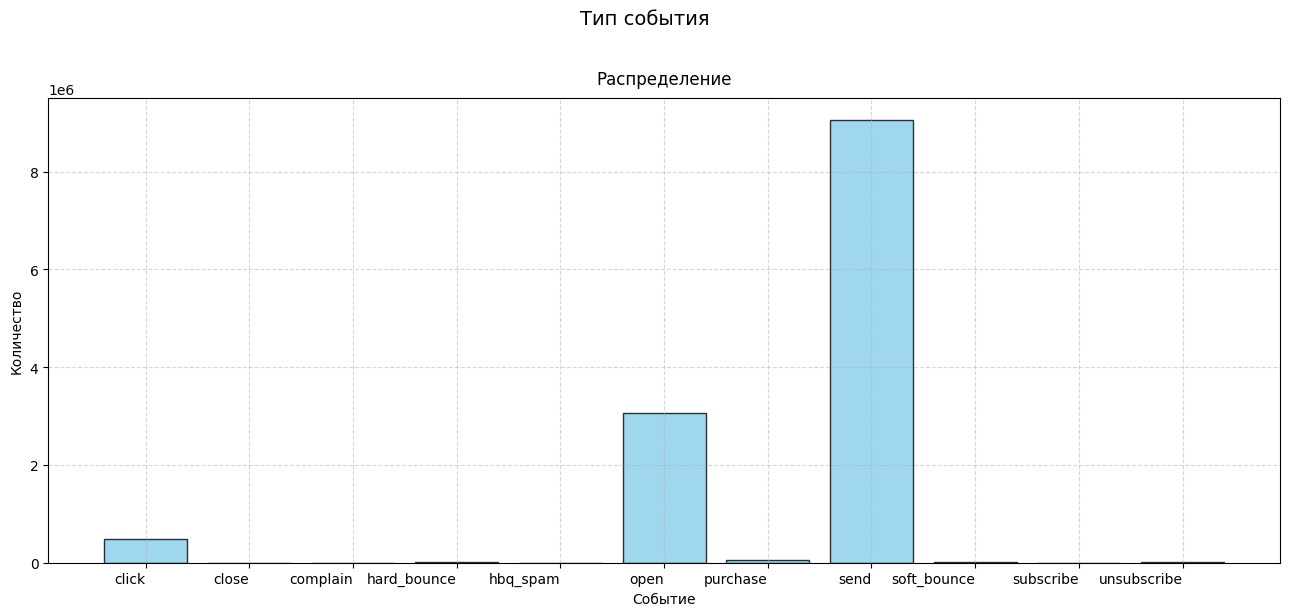

count     12691188
unique          11
top           send
freq       9058174
Name: event, dtype: object

In [536]:
# выведем график распределения
plot_data_analysis(app_messages['event'],
                   title = 'Тип события',
                   x_label = 'Событие',
                   y_label = 'Количество',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [537]:
# посмотрим количество значений
app_messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

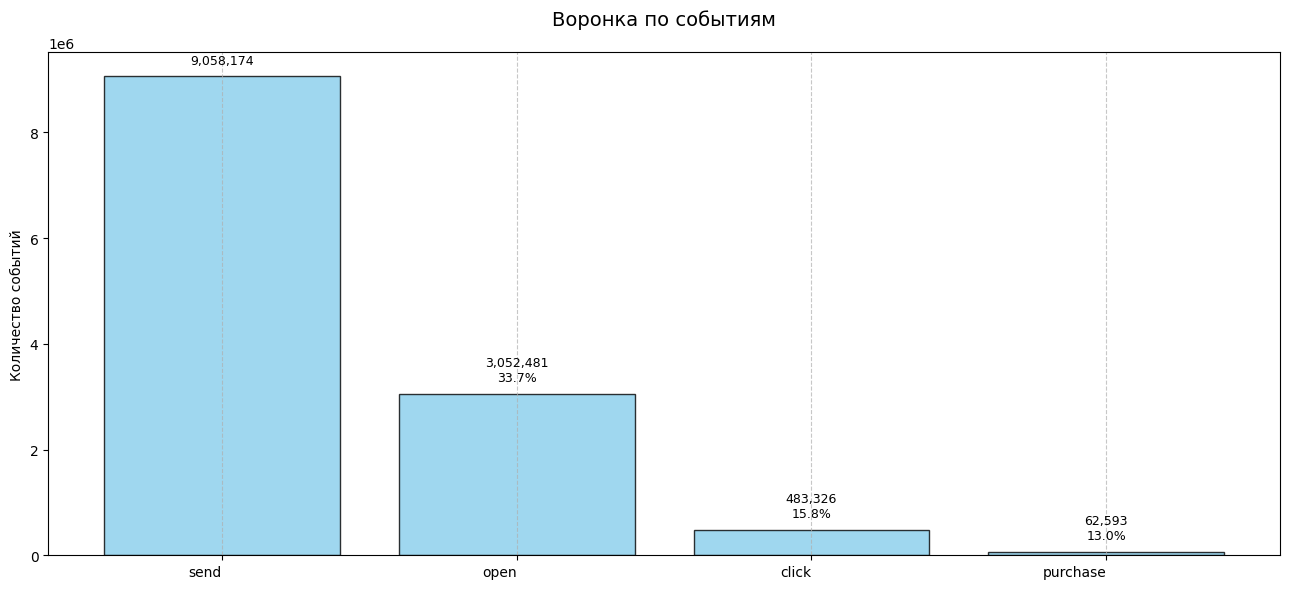

Статистика воронки:
send                       9,058,174: (100.0%)
open                       3,052,481: (33.7% | 33.7%)
click                        483,326: (15.8% | 5.3%)
purchase                      62,593: (13.0% | 0.7%)
Общая конверсия: 0.69%
Потери: 8,995,581 событий


In [538]:
# построим маркетинговую воронку по событиям
plot_funnel(
    app_messages,
    'event',
    ['send', 'open', 'click', 'purchase'],
    title = 'Воронка по событиям',
    orientation = 'horizontal'
)

**Промежуточный вывод**: на основе имеющейся информации о события, можно оценить общую конверсию -- $\sim0.71\%$. При этом из общего количества сообщений $34.1\%$ были открыты, $16.1%$ затем прокликаны и $13\%$ пользователей совершили покупку.

#### Признак ```channel```

**Комментарий**: рассмотрим подробнее признак ```channel``` -- канал рассылки.

In [539]:
# посмотрим уникальные значения в столбце channel
app_messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

**Комментарий**: видим два уникальных типа рассылки в ```channel```:
- `email` - рассылка по электронной почте;
- `mobile_push` - рассылка через push-уведомления. 

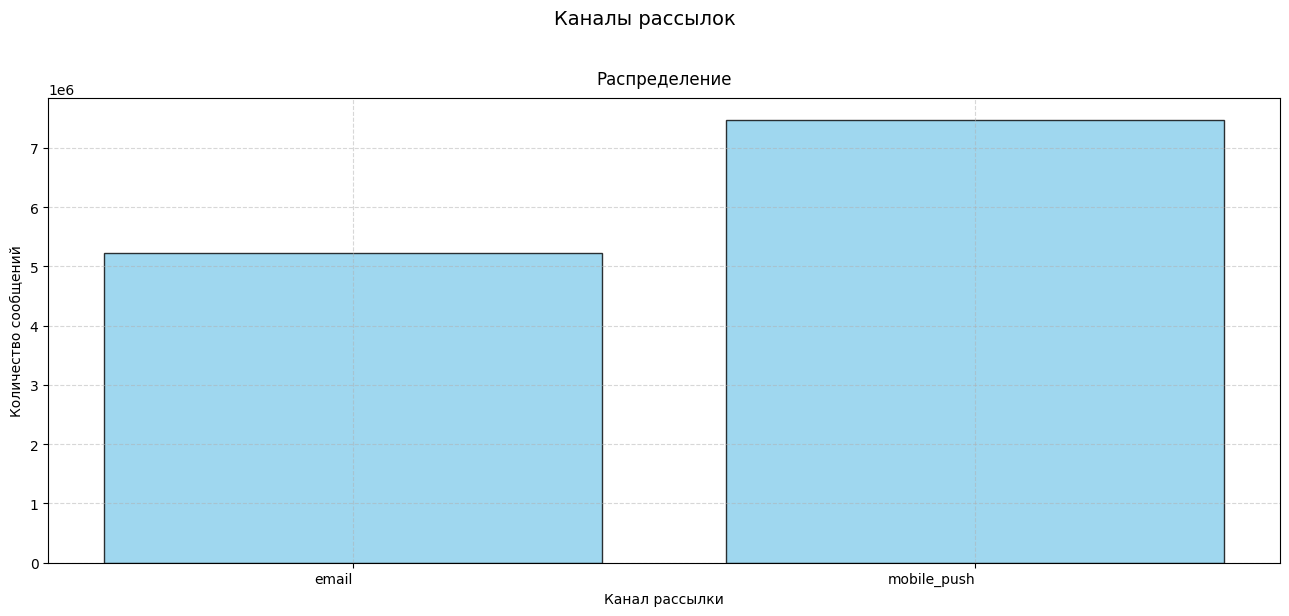

count        12691188
unique              2
top       mobile_push
freq          7470472
Name: channel, dtype: object

In [540]:
# выведем график распределения
plot_data_analysis(app_messages['channel'],
                   title = 'Каналы рассылок',
                   x_label = 'Канал рассылки',
                   y_label = 'Количество сообщений',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [ ]:
# посмотрим количество значений
app_messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

**Промежуточный вывод**:

#### Промежуточный вывод

### Таблица ```app_target```

**Комментарий**: исследуем таблицу ```app_target``` -- целевой признак -- совершит ли клиент покупку в течение следующих 90 дней.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [285]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_target['client_id'].nunique()}')

Уникальных клиентов: 49849


**Промежуточный вывод**: в данных содержится **49849** уникальных клиентов (совпадает с ```app_purchase```).

#### Признак ```target```

**Комментарий**: рассмотрим подробнее признак ```target``` -- целевой признак.

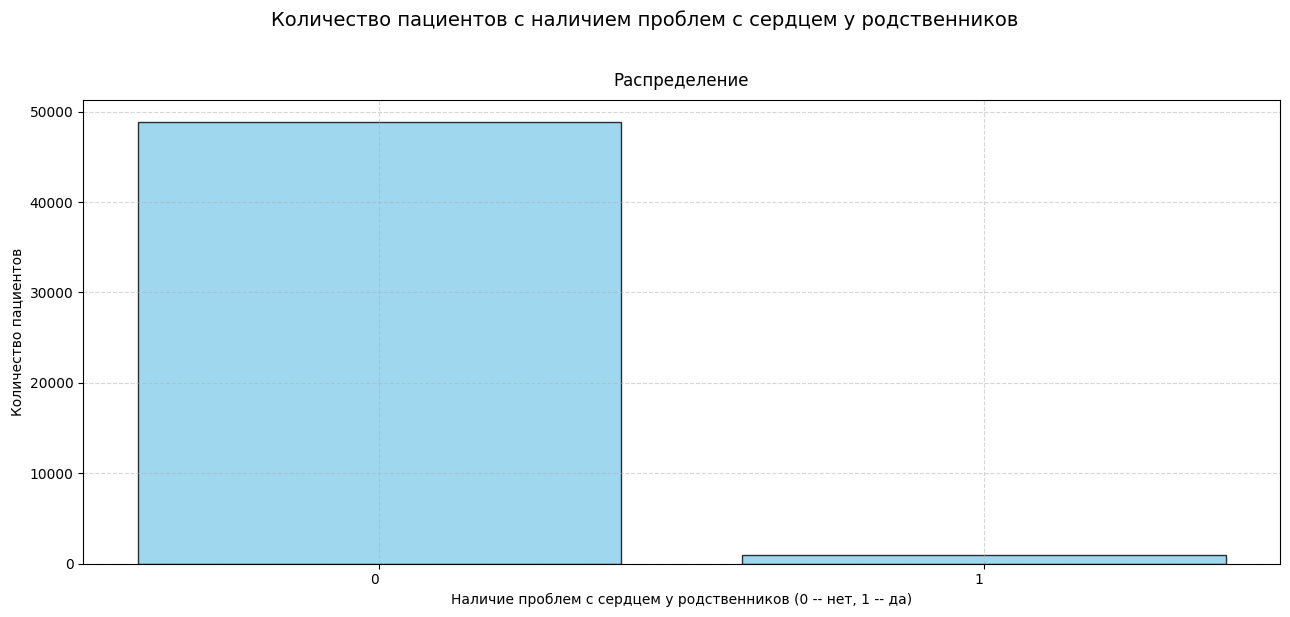

count    49849.000000
mean         0.019278
std          0.137503
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64

In [182]:
# выведем график распределения
plot_data_analysis(app_target['target'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [286]:
# посмотрим количество значений
app_target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

**Комментарий**: сильнейший дисбаланс! стратификация, балансировка выборок и весов в моделях, десемплирование?

**Промежуточный вывод**:

### Таблица ```fc_daily```

**Комментарий**: исследуем таблицу ```fc_daily``` -- агрегация общей базы рассылок по дням и типам событий.

In [252]:
fc_daily['bulk_campaign_id'].nunique()

3181

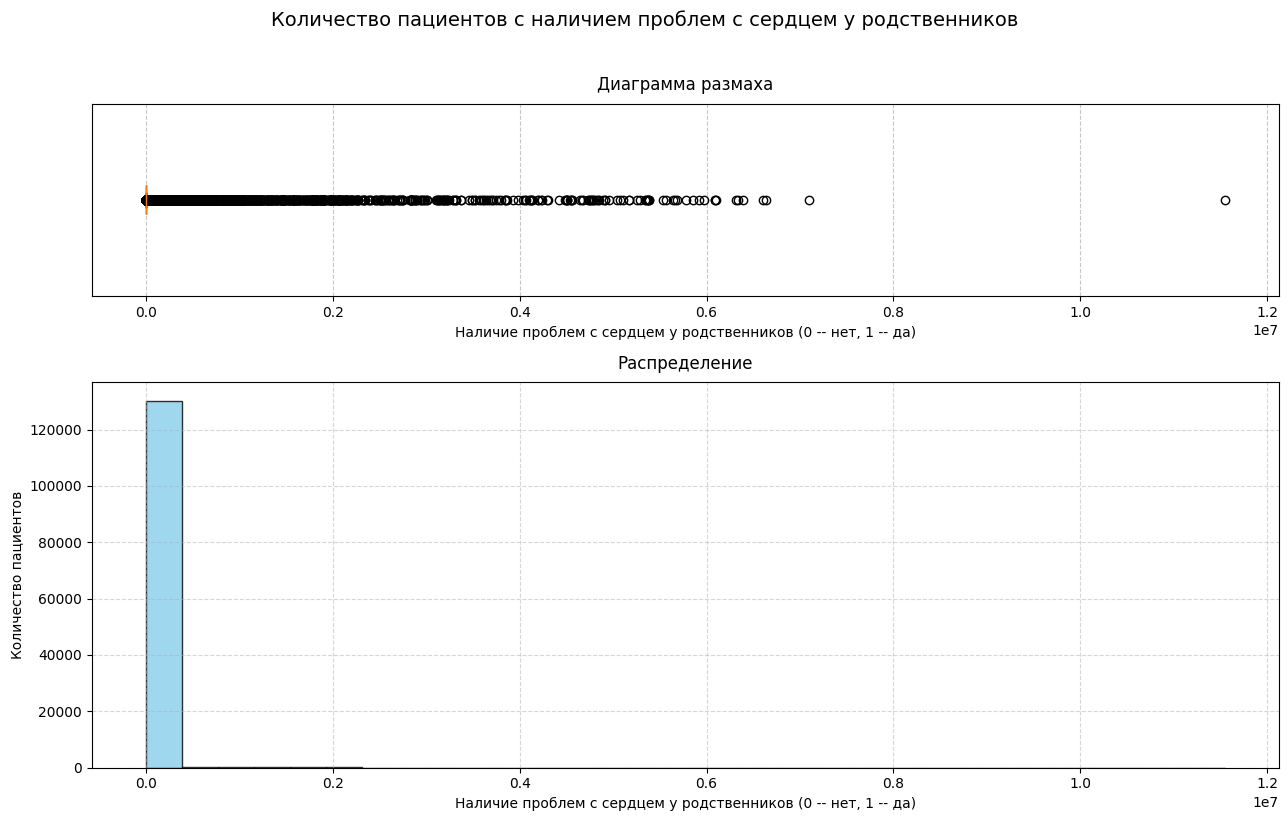

count    1.310720e+05
mean     1.163414e+04
std      1.757095e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.154351e+07
Name: count_send, dtype: float64

In [253]:
# выведем график распределения
plot_data_analysis(fc_daily['count_send'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 30
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_send'].value_counts()

count_send
0          127323
1              43
11520          34
4              23
2              22
            ...  
1605            1
1403952         1
270838          1
748             1
467884          1
Name: count, Length: 2821, dtype: int64

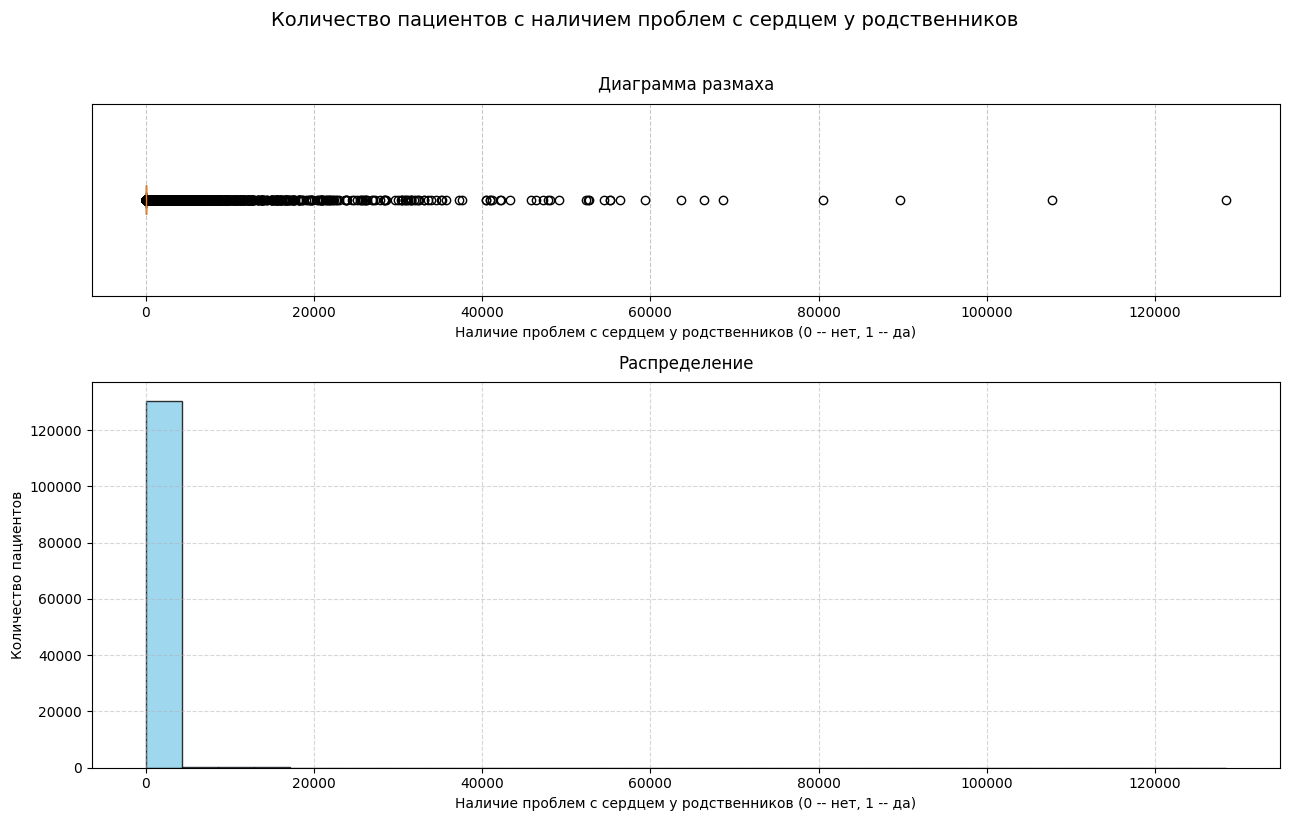

count    131072.000000
mean         90.982971
std        1275.503564
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      128453.000000
Name: count_click, dtype: float64

In [255]:
# выведем график распределения
plot_data_analysis(fc_daily['count_click'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 30
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_click'].value_counts()

count_click
0        76615
1        18161
2         6814
3         3588
4         2239
         ...  
7436         1
15040        1
2069         1
858          1
15038        1
Name: count, Length: 2284, dtype: int64

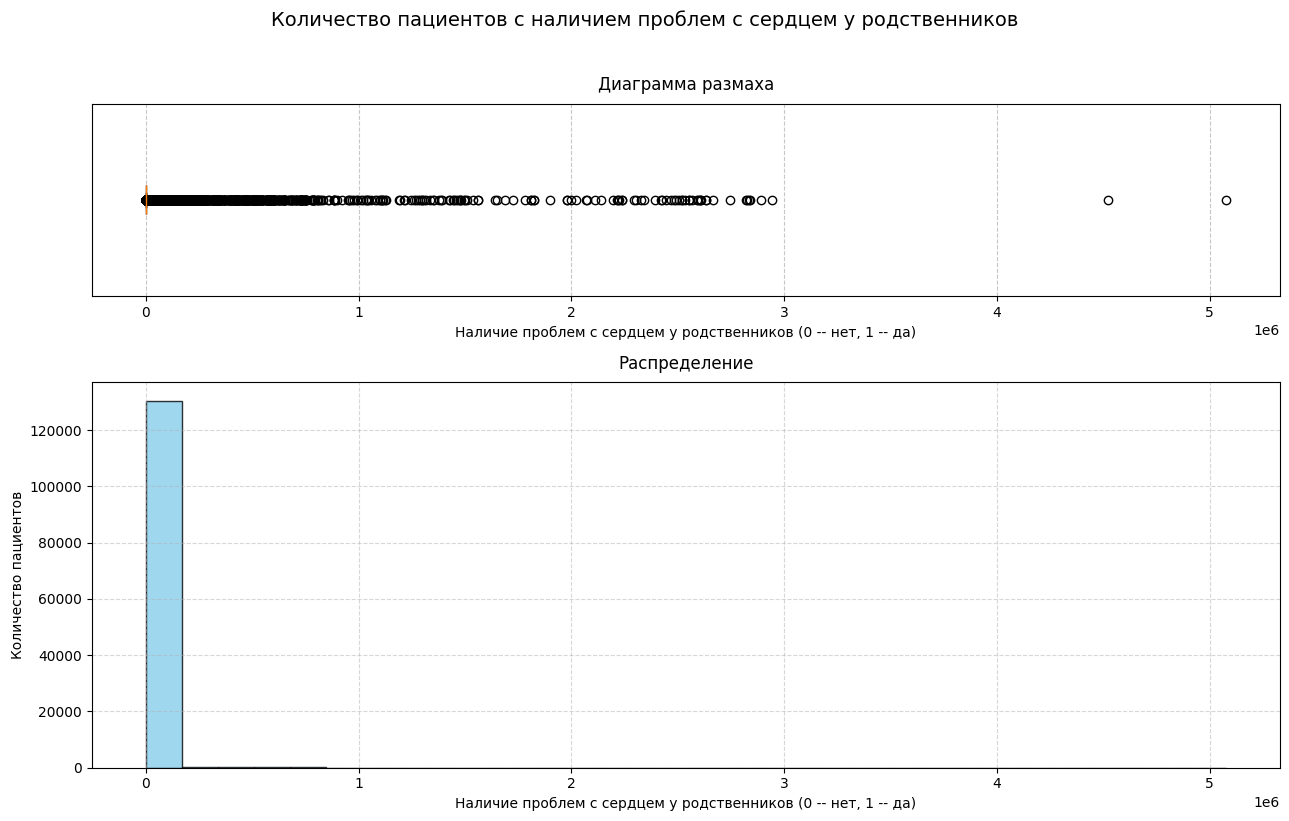

count    1.310720e+05
mean     3.771091e+03
std      6.516067e+04
min      0.000000e+00
25%      1.000000e+00
50%      6.000000e+00
75%      3.000000e+01
max      5.076151e+06
Name: count_open, dtype: float64

In [257]:
# выведем график распределения
plot_data_analysis(fc_daily['count_open'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 30
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_open'].value_counts()

count_open
0          22738
1          14104
2           8783
3           6518
4           5216
           ...  
131986         1
10992          1
539026         1
6507           1
2222349        1
Name: count, Length: 5321, dtype: int64

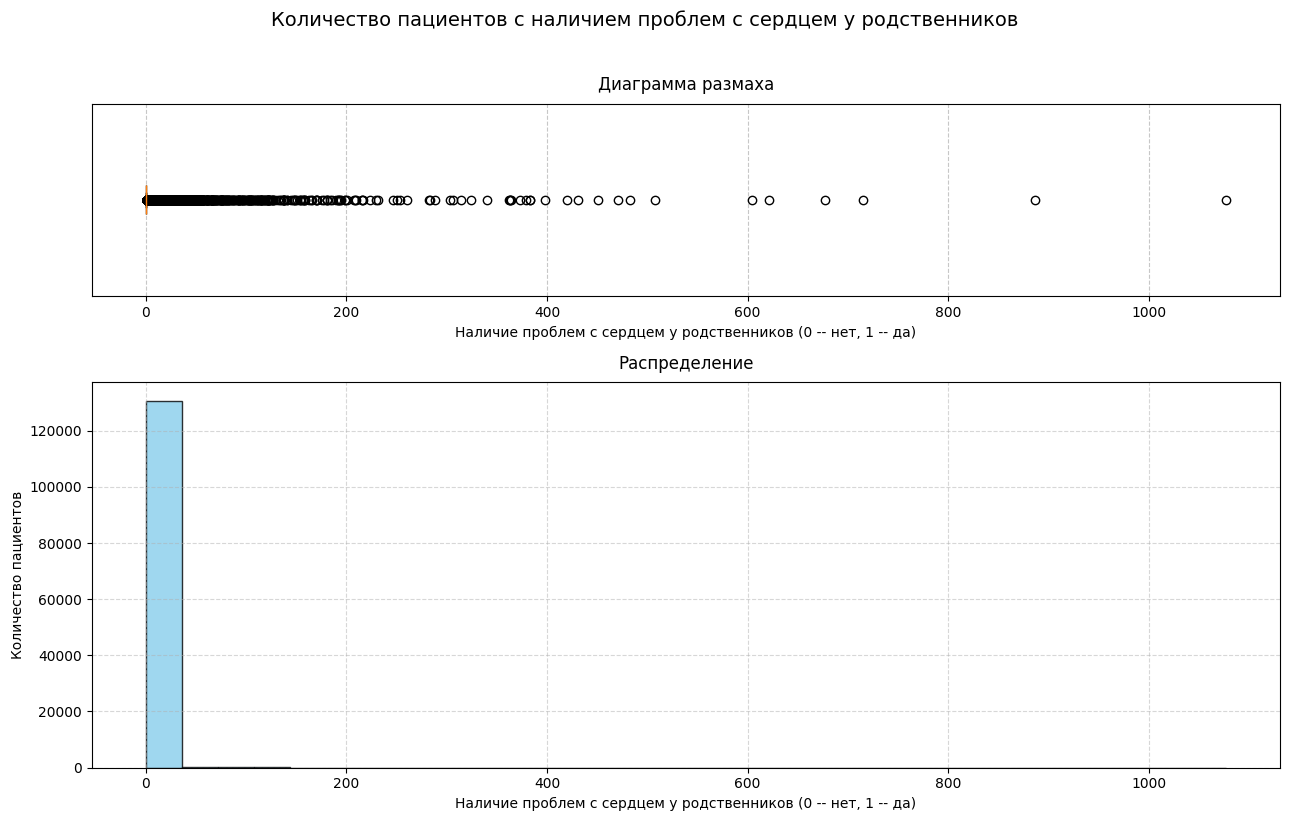

count    131072.000000
mean          0.577927
std           9.107040
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1077.000000
Name: count_purchase, dtype: float64

In [259]:
# выведем график распределения
plot_data_analysis(fc_daily['count_purchase'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 30
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_purchase'].value_counts()

count_purchase
0      123323
1        3328
2        1162
3         643
4         432
        ...  
184         1
193         1
207         1
420         1
431         1
Name: count, Length: 192, dtype: int64

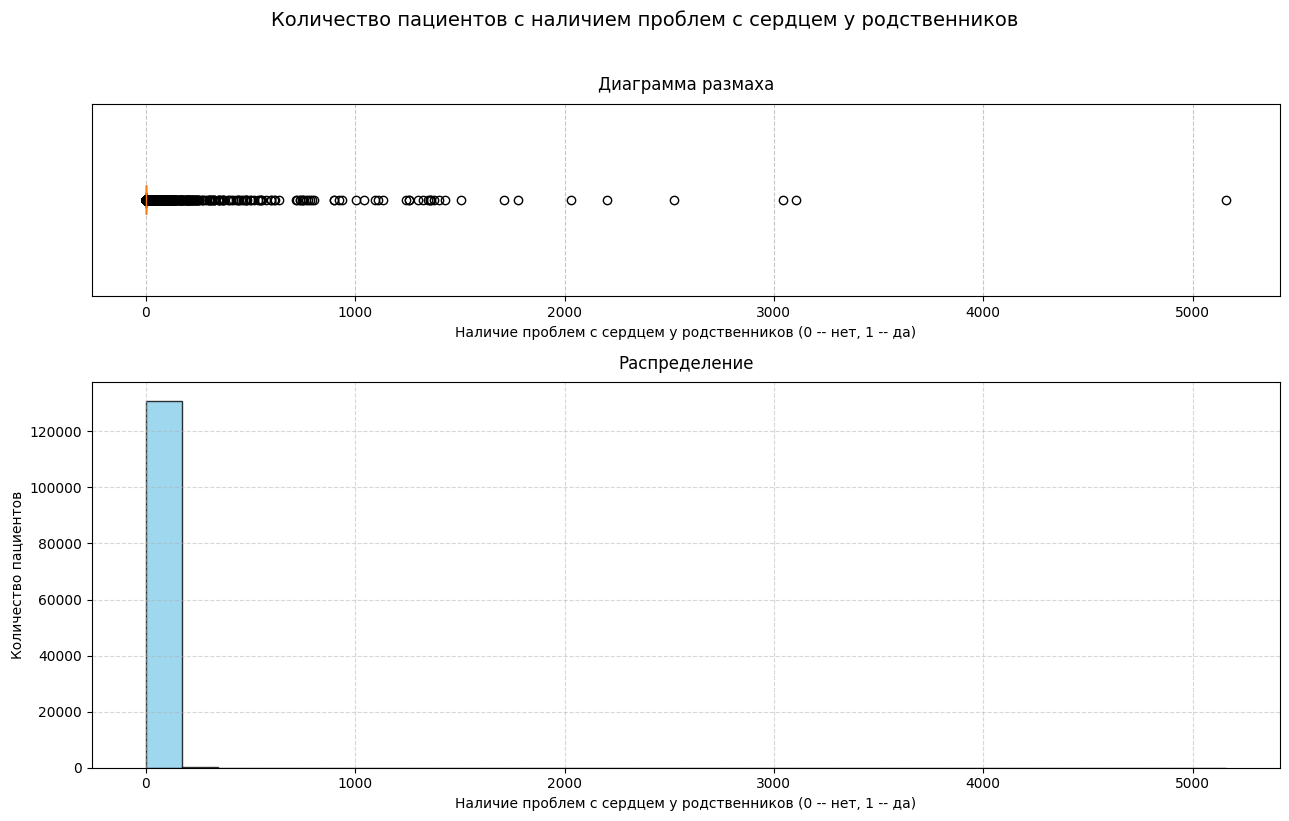

count    131072.000000
mean          0.932655
std          30.198326
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        5160.000000
Name: count_complain, dtype: float64

In [261]:
# выведем график распределения
plot_data_analysis(fc_daily['count_complain'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 30
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_complain'].value_counts()

count_complain
0      122364
1        5053
2        1418
3         605
4         374
        ...  
46          1
108         1
87          1
57          1
86          1
Name: count, Length: 249, dtype: int64

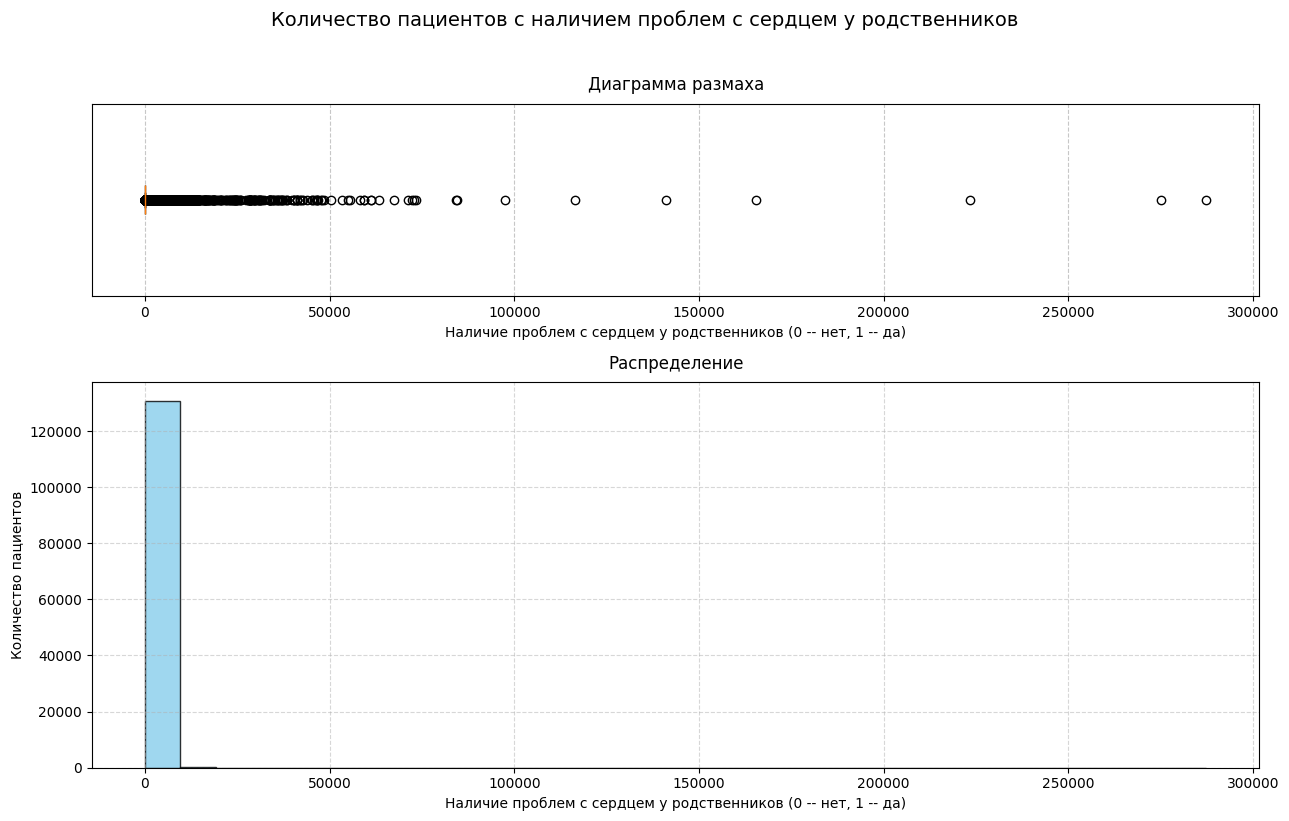

count    131072.000000
mean         78.473434
std        1961.317826
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      287404.000000
Name: count_hard_bounce, dtype: float64

In [263]:
# выведем график распределения
plot_data_analysis(fc_daily['count_hard_bounce'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 30
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_hard_bounce'].value_counts()

count_hard_bounce
0        127912
1           296
2           141
3            70
4            68
          ...  
4578          1
1269          1
851           1
1822          1
34822         1
Name: count, Length: 1283, dtype: int64

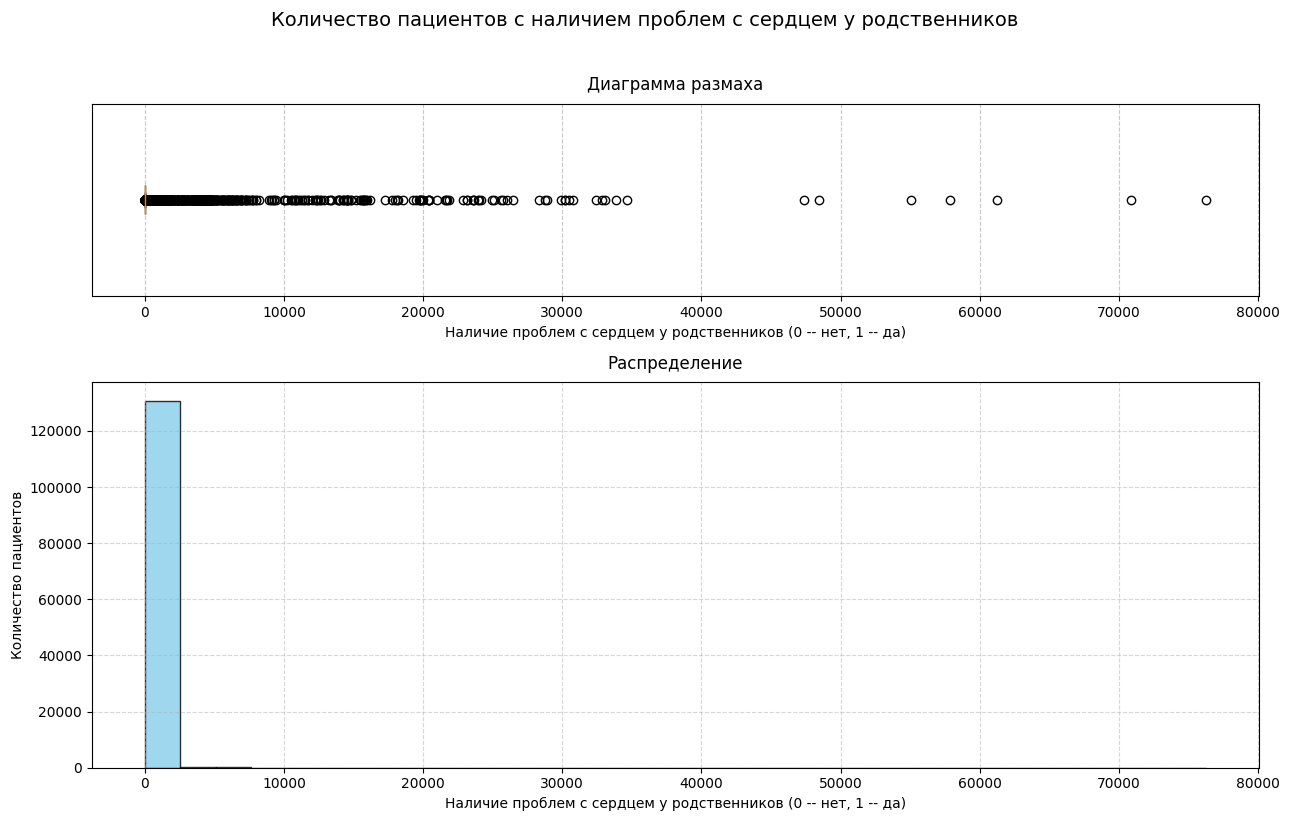

count    131072.000000
mean         27.807312
std         736.944714
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       76284.000000
Name: count_soft_bounce, dtype: float64

In [265]:
# выведем график распределения
plot_data_analysis(fc_daily['count_soft_bounce'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 30
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_soft_bounce'].value_counts()

count_soft_bounce
0        129020
1           406
2           178
3           114
4            98
          ...  
4881          1
25591         1
11147         1
2271          1
1000          1
Name: count, Length: 741, dtype: int64

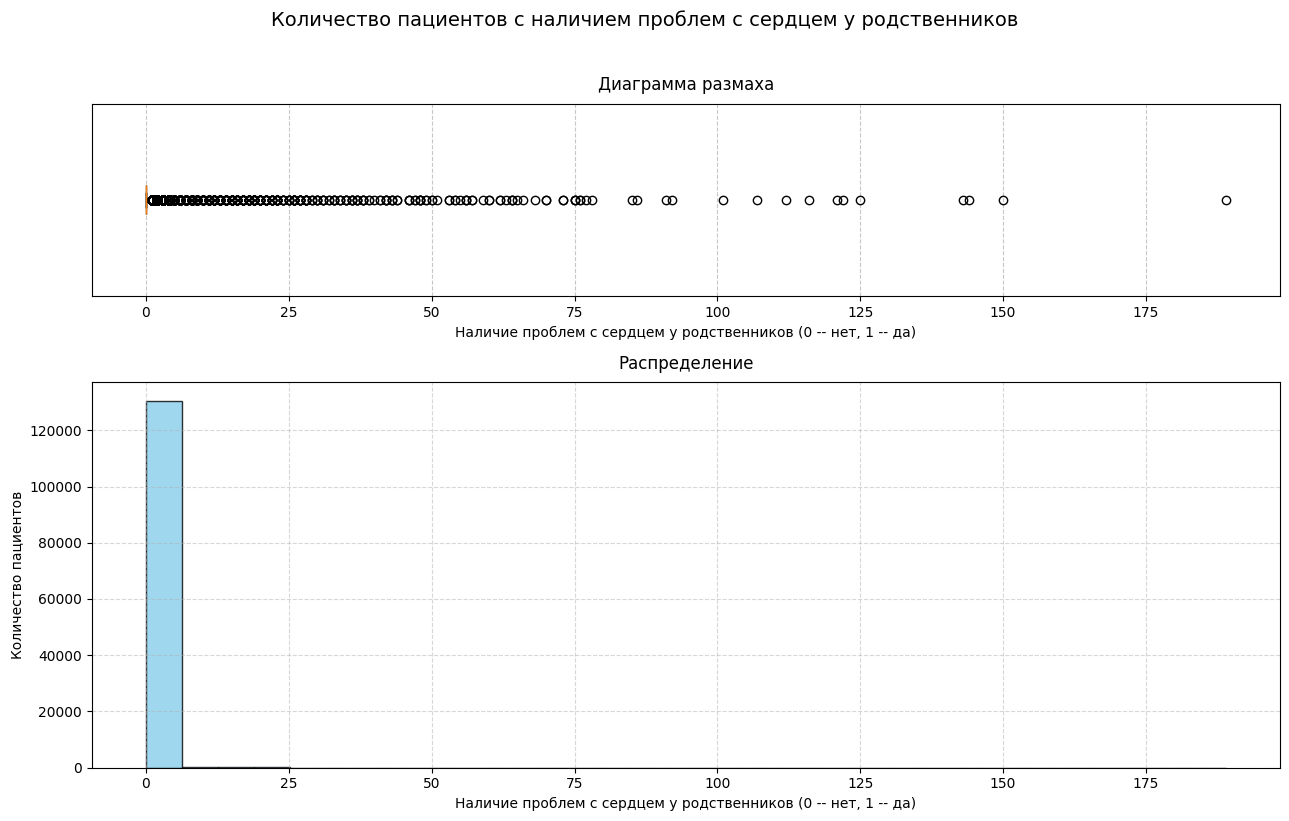

count    131072.000000
mean          0.140518
std           2.072777
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         189.000000
Name: count_subscribe, dtype: float64

In [267]:
# выведем график распределения
plot_data_analysis(fc_daily['count_subscribe'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 30
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_subscribe'].value_counts()

count_subscribe
0      126719
1        2540
2         623
3         286
4         168
        ...  
107         1
77          1
143         1
101         1
59          1
Name: count, Length: 85, dtype: int64

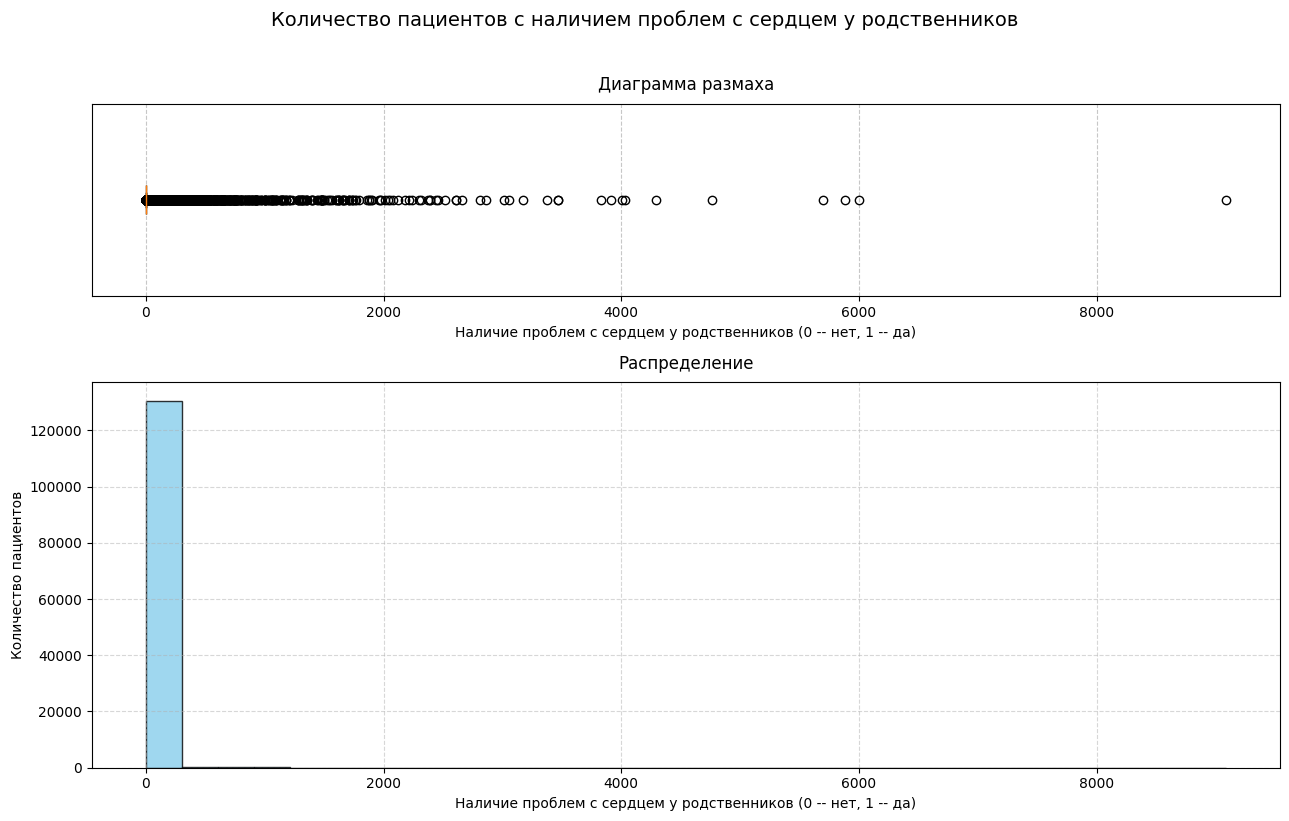

count    131072.000000
mean          6.362679
std          79.172069
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        9089.000000
Name: count_unsubscribe, dtype: float64

In [ ]:
# выведем график распределения
plot_data_analysis(fc_daily['count_unsubscribe'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = False,
                   plot_box = True,
                   bins = 32
                   )

In [ ]:
# посмотрим количество значений
fc_daily['count_unsubscribe'].value_counts()

count_unsubscribe
0       93527
1       16002
2        6194
3        3083
4        1894
        ...  
416         1
1481        1
397         1
2238        1
331         1
Name: count, Length: 697, dtype: int64

### Таблица ```fc_daily_channel```

**Комментарий**: исследуем таблицу ```fc_daily_channel``` -- агрегация по дням с учетом событий и каналов рассылки.

### Объединение данных

In [203]:
# Объединяем нахуй все данные по client_id

# 1. Базовый датафрейм - все уникальные client_id
all_client_ids = set(app_purchases['client_id']).union(set(app_messages['client_id'])).union(set(app_target['client_id']))
master = pd.DataFrame({'client_id': list(all_client_ids)})
print(f"Всего пользователей: {len(master)}")

# 2. Добавляем таргет
master = master.merge(app_target, on='client_id', how='left')
master['target'] = master['target'].fillna(0).astype(int)
print(f"Пользователей с target=1: {master['target'].sum()}")

# 3. Аггрегируем фичи из покупок
purchase_features = app_purchases.groupby('client_id').agg({
    'quantity': ['sum', 'mean', 'count'],
    'price': ['sum', 'mean', 'min', 'max', 'std'],
    'date': ['min', 'max']
}).round(2)

# Выравниваем колонки
purchase_features.columns = [f'purchase_{col[0]}_{col[1]}' for col in purchase_features.columns]
purchase_features = purchase_features.reset_index()

master = master.merge(purchase_features, on='client_id', how='left')

# 4. Фичи из категорий
category_features = app_purchases.groupby('client_id').agg({
    'category_ids': 'nunique'
}).reset_index()
category_features.columns = ['client_id', 'purchase_unique_categories']

master = master.merge(category_features, on='client_id', how='left')

# 5. Фичи из рассылок
message_features = app_messages.groupby('client_id').agg({
    'message_id': 'count',
    'bulk_campaign_id': 'nunique', 
    'event': 'nunique',
    'channel': 'nunique',
    'date': ['min', 'max']
}).round(2)

message_features.columns = [f'message_{col[0]}_{col[1]}' for col in message_features.columns]
message_features = message_features.reset_index()

master = master.merge(message_features, on='client_id', how='left')

# 6. Фичи по событиям рассылок (разбиваем event по типам)
event_features = pd.crosstab(app_messages['client_id'], app_messages['event'])
event_features.columns = [f'event_{col}' for col in event_features.columns]
event_features = event_features.reset_index()

master = master.merge(event_features, on='client_id', how='left')

print(f"Размер мастер-датасета: {master.shape}")
print(f"Колонки: {list(master.columns)}")

Всего пользователей: 61196
Пользователей с target=1: 961
Размер мастер-датасета: (61196, 30)
Колонки: ['client_id', 'target', 'purchase_quantity_sum', 'purchase_quantity_mean', 'purchase_quantity_count', 'purchase_price_sum', 'purchase_price_mean', 'purchase_price_min', 'purchase_price_max', 'purchase_price_std', 'purchase_date_min', 'purchase_date_max', 'purchase_unique_categories', 'message_message_id_count', 'message_bulk_campaign_id_nunique', 'message_event_nunique', 'message_channel_nunique', 'message_date_min', 'message_date_max', 'event_click', 'event_close', 'event_complain', 'event_hard_bounce', 'event_hbq_spam', 'event_open', 'event_purchase', 'event_send', 'event_soft_bounce', 'event_subscribe', 'event_unsubscribe']


## <u>Корреляционный анализ</u>

In [213]:
master.drop(columns=['client_id'], inplace=True)

In [214]:
# сформируем список столбцов с непрерывными признаками
interval_columns = [
    'purchase_quantity_sum', 'purchase_quantity_mean', 'purchase_quantity_count',
    'purchase_price_sum', 'purchase_price_mean', 'purchase_price_min', 
    'purchase_price_max', 'purchase_price_std', 'purchase_unique_categories',
    'message_message_id_count', 'message_bulk_campaign_id_nunique',
    'message_event_nunique', 'message_channel_nunique',
    'event_click', 'event_close', 'event_complain', 'event_hard_bounce',
    'event_hbq_spam', 'event_open', 'event_purchase', 'event_send',
    'event_soft_bounce', 'event_subscribe', 'event_unsubscribe', 'target'
]

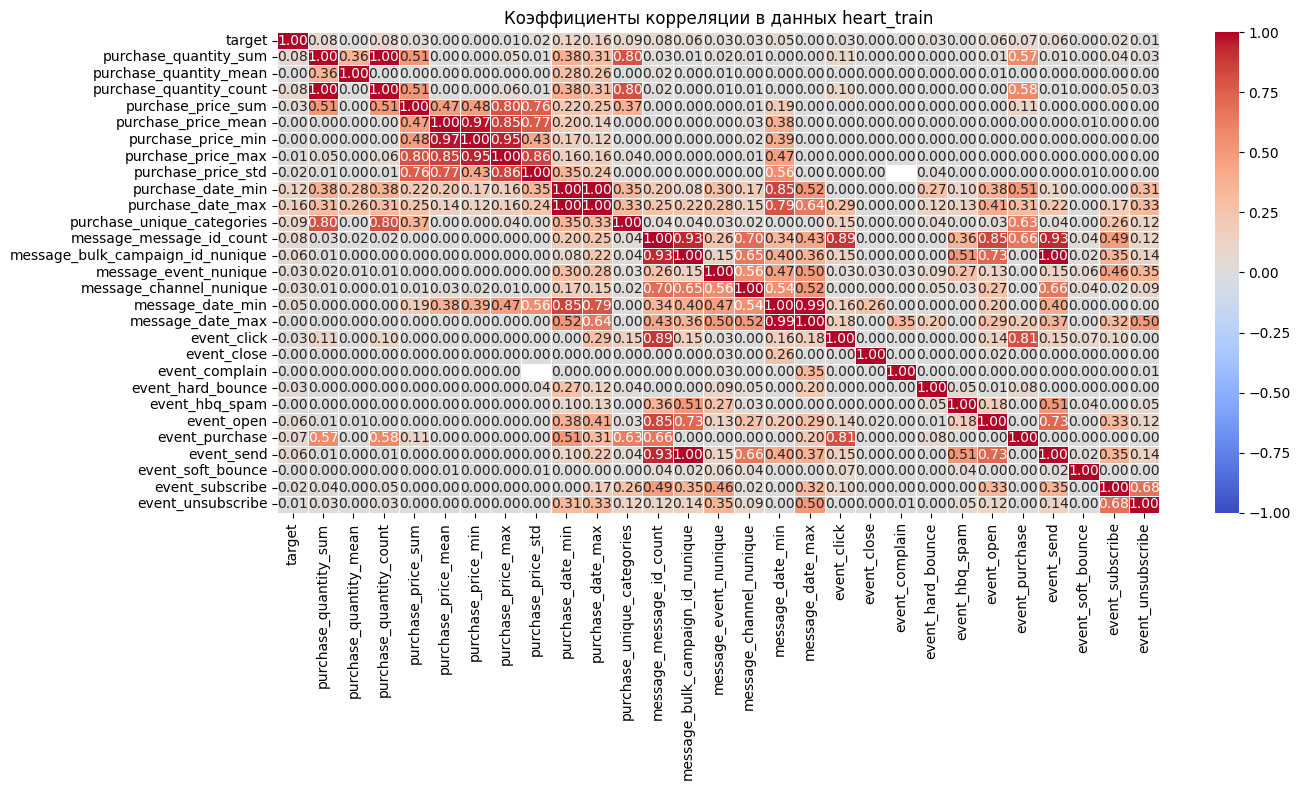

,target,purchase_quantity_sum,purchase_quantity_mean,purchase_quantity_count,purchase_price_sum,purchase_price_mean,purchase_price_min,purchase_price_max,purchase_price_std,purchase_date_min,...,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe
target,1.000000,0.081293,0.000000,0.083996,0.034585,0.000000,0.000000,0.009358,0.022669,0.123334,...,0.000000,0.000000,0.032687,0.000000,0.055791,0.072861,0.063357,0.000000,0.015725,0.011723
purchase_quantity_sum,0.081293,1.000000,0.356101,0.999279,0.512547,0.000000,0.000000,0.054682,0.007733,0.377177,...,0.000000,0.000000,0.000000,0.000000,0.014242,0.574529,0.011447,0.000000,0.044935,0.026331
purchase_quantity_mean,0.000000,0.356101,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.276791,...,0.000000,0.000000,0.000000,0.000000,0.014728,0.000000,0.000000,0.000000,0.000000,0.000000
purchase_quantity_count,0.083996,0.999279,0.000000,1.000000,0.513434,0.000000,0.000000,0.056477,0.011892,0.377664,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.579319,0.008117,0.000000,0.046462,0.028600
purchase_price_sum,0.034585,0.512547,0.000000,0.513434,1.000000,0.472483,0.481787,0.799252,0.755159,0.215008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.111486,0.000000,0.000000,0.000000,0.000000
purchase_price_mean,0.000000,0.000000,0.000000,0.000000,0.472483,1.000000,0.974589,0.854108,0.771810,0.200714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005319,0.000000,0.000000
purchase_price_min,0.000000,0.000000,0.000000,0.000000,0.481787,0.974589,1.000000,0.946001,0.428030,0.171392,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
purchase_price_max,0.009358,0.054682,0.000000,0.056477,0.799252,0.854108,0.946001,1.000000,0.856757,0.157142,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
purchase_price_std,0.022669,0.007733,0.000000,0.011892,0.755159,0.771810,0.428030,0.856757,1.000000,0.347942,...,0.000000,NaN,0.037021,0.000000,0.000000,0.000000,0.000000,0.013003,0.000000,0.000000
purchase_date_min,0.123334,0.377177,0.276791,0.377664,0.215008,0.200714,0.171392,0.157142,0.347942,1.000000,...,0.000000,0.000000,0.267630,0.095674,0.375872,0.511936,0.102886,0.000000,0.000000,0.313696


In [215]:
# рассчитаем корреляцию и построим матрицу коэффициентов корреляции и тепловую карту
corr_matrix = plot_corr_heatmap(master,
                                title = 'Коэффициенты корреляции в данных heart_train',
                                columns = interval_columns)
display(corr_matrix)

In [216]:
# проведем беглый анализ корреляционной матрицы
corr_res = corr_analysis(corr_matrix, target_feature='target', min_abs_corr=1e-8)

In [217]:
# выведем результаты анализа корреляционной матрицы
display(corr_res)

,Признак,Корреляция,Сила связи,Направление
0,purchase_date_max,0.164,Слабая,положительная
1,purchase_date_min,0.123,Слабая,положительная
2,purchase_unique_categories,0.089,Очень слабая,положительная
3,purchase_quantity_count,0.084,Очень слабая,положительная
4,purchase_quantity_sum,0.081,Очень слабая,положительная
5,message_message_id_count,0.077,Очень слабая,положительная
6,event_purchase,0.073,Очень слабая,положительная
7,event_send,0.063,Очень слабая,положительная
8,message_bulk_campaign_id_nunique,0.063,Очень слабая,положительная
9,event_open,0.056,Очень слабая,положительная


## <u>Отбор и подготовка признаков</u>

## <u>Обучение модели</u>

**Комментарий**: перейдем теперь к подготовки данных и обучению модели.

Для CV будем использовать `roc_auc`, а на валидационной выборке полную метрику (следим за ```precision```, ```recall```, ```f1/f2```).

В целом не ясно, какую задачу будет решать модель, поэтому также оставим возможность настройки порога между ```precision``` и ```recall``` и будем искать исходя из баланса и того, и другого (построим кривую `precision-recall`). Возможность изменить порог в дальнейшем заложим в функционал приложения.

Для чего это нужно: при максимизации `recall` мы будет чаще находить пациентов, которые действительно обладают риском, однако вместе с ними чаще будем предсказывать риск здоровым пациентам. В этом случае мы можем создать нагрузку на систему здравоохранения, отправляя здоровых на доп. исследования. В ином случае, при низком `recall` сиутация становится с точностью да наоборот.

Поэтому еще раз следует подчеркнуть -- т.к. не сформулирована окончательная задача, где и как будет использоваться модель, то внедряем возможность менять порог.

### Подготовка данных

In [226]:
master.drop(columns=['purchase_date_max', 'purchase_date_min', 'message_date_min', 'message_date_max'], inplace=True)

In [227]:
X = master.drop('target', axis=1)
y = master['target']
target_feature = 'target'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y  # сохраняем пропорции целевого признака
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_test)}\n")
print(f"Пропроция целевого признака в обучающей выборке:\n{y_train.value_counts(normalize=True)}\n")
print(f"Пропроция целевого признака в валидационной выборке:\n{y_test.value_counts(normalize=True)}")

Размер обучающей выборки: 45897
Размер валидационной выборки: 15299

Пропроция целевого признака в обучающей выборке:
target
0    0.984291
1    0.015709
Name: proportion, dtype: float64

Пропроция целевого признака в валидационной выборке:
target
0    0.984313
1    0.015687
Name: proportion, dtype: float64


In [228]:
# формируем списки признаков
num_columns = master.drop(columns=['target']).columns.tolist()

In [229]:
# количественные признаки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# препроцессор
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns)
    ])

In [230]:
# составим список моделей и наборов гиперпараметров
scalers = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
}
models = [
    {
        'model': DummyClassifier(),
        'params': {
            'model__strategy': ['stratified', 'most_frequent', 'prior', 'uniform'],
            **scalers
        },
        'name': 'Dummy'
    },
    {
        'model': LogisticRegression(random_state=RANDOM_STATE),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l1', 'l2', 'elasticnet'],
            'model__solver': ['liblinear', 'saga'],
            'model__max_iter': [1000],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'LogisticRegression'
    },
    {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__max_depth': [3, 5, 7, 10, 12, 14, 16, 18],
            'model__min_samples_split': [2, 5, 10, 12, 14, 16, 18],
            'model__min_samples_leaf': [1, 2, 4, 6, 8],
            'model__criterion': ['gini', 'entropy'],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'DecisionTreeClassifier'
    },
    {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [50, 100, 200, 500, 1000],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 4, 5, 6],
            'model__subsample': [0.4, 0.6, 0.8, 1.0],
            **scalers
        },
        'name': 'GradientBoostingClassifier'
    },
    {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan', 'minkowski'],
            **scalers
        },
        'name': 'KNeighborsClassifier'
    },
    {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200, 300, 500, 1000],
            'model__max_depth': [5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'RandomForestClassifier'
    },
    {
        'model': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200, 300, 500, 1000],
            'model__max_depth': [3, 6, 9],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__subsample': [0.8, 0.9, 1.0],
            'model__colsample_bytree': [0.8, 0.9, 1.0],
            'model__scale_pos_weight': [1, len(y_train[y_train==0])/len(y_train[y_train==1])],
            'model__verbose': [0],
            **scalers
        },
        'name': 'XGBClassifier'
    },
    {
    'model': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False),
    'params': {
        'model__iterations': [100, 200, 500, 1000],
        'model__depth': [4, 6, 8, 12],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5, 7],
        'model__border_count': [32, 64, 128],
        **scalers
    },
    'name': 'CatBoostClassifier'
}
]

In [231]:
# в цикле выполним подбор параметров, замеряем время обучения, предсказания и подборов параметров
results = []
for mdl in models:
    results.append(evaluate_model(mdl['model'], 
                                  mdl['params'], 
                                  mdl['name'],
                                  X_train,
                                  y_train,
                                  data_preprocessor,
                                  data_preprocessor,
                                  refit_metric='roc_auc',
                                  random_state = RANDOM_STATE,
                                  cv=5,
                                  n_iter=10))

Модель: Dummy
Лучшие параметры: {'preprocessor__num__scaler': 'passthrough', 'model__strategy': 'stratified'}
Время подбора параметров: 1.430 с.
Время обучения лучшей модели: 0.290 с.
Время предсказания лучшей модели: 0.069 с.
Accuracy на кросс-валидации: 0.9688
Precision на кросс-валидации: 0.0149
Recall на кросс-валидации: 0.0153
ROC-AUC на кросс-валидации: 0.5008
F1-score на кросс-валидации: 0.0151
F2-score на кросс-валидации: 0.0152
Average Precision на кросс-валидации: 0.0160

Для линейной модели LogisticRegression используется OneHotEncoder


d:\Programs\Python\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programs\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programs\Python\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Programs\Python\Lib\site-packages\imblearn\pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **last_step_pa

Модель: LogisticRegression
Лучшие параметры: {'preprocessor__num__scaler': RobustScaler(), 'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__max_iter': 1000, 'model__class_weight': 'balanced', 'model__C': 10.0}
Время подбора параметров: 12.569 с.
Время обучения лучшей модели: 2.275 с.
Время предсказания лучшей модели: 0.032 с.
Accuracy на кросс-валидации: 0.7206
Precision на кросс-валидации: 0.0320
Recall на кросс-валидации: 0.5742
ROC-AUC на кросс-валидации: 0.7098
F1-score на кросс-валидации: 0.0606
F2-score на кросс-валидации: 0.1309
Average Precision на кросс-валидации: 0.0496

Для нелинейной модели DecisionTreeClassifier используется OrdinalEncoder
Модель: DecisionTreeClassifier
Лучшие параметры: {'preprocessor__num__scaler': MinMaxScaler(), 'model__min_samples_split': 18, 'model__min_samples_leaf': 6, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': None}
Время подбора параметров: 1.697 с.
Время обучения лучшей модели: 0.406 с.
Время предсказа

d:\Programs\Python\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:32:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Модель: XGBClassifier
Лучшие параметры: {'preprocessor__num__scaler': MinMaxScaler(), 'model__verbose': 0, 'model__subsample': 0.9, 'model__scale_pos_weight': 1, 'model__n_estimators': 500, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}
Время подбора параметров: 11.500 с.
Время обучения лучшей модели: 1.791 с.
Время предсказания лучшей модели: 0.104 с.
Accuracy на кросс-валидации: 0.9843
Precision на кросс-валидации: 0.0000
Recall на кросс-валидации: 0.0000
ROC-AUC на кросс-валидации: 0.7536
F1-score на кросс-валидации: 0.0000
F2-score на кросс-валидации: 0.0000
Average Precision на кросс-валидации: 0.0501

Для нелинейной модели CatBoostClassifier используется OrdinalEncoder


d:\Programs\Python\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programs\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programs\Python\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Programs\Python\Lib\site-packages\imblearn\pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **last_step_para

Модель: CatBoostClassifier
Лучшие параметры: {'preprocessor__num__scaler': StandardScaler(), 'model__learning_rate': 0.03, 'model__l2_leaf_reg': 7, 'model__iterations': 1000, 'model__depth': 4, 'model__border_count': 128}
Время подбора параметров: 39.408 с.
Время обучения лучшей модели: 24.540 с.
Время предсказания лучшей модели: 0.073 с.
Accuracy на кросс-валидации: 0.9843
Precision на кросс-валидации: 0.3000
Recall на кросс-валидации: 0.0028
ROC-AUC на кросс-валидации: 0.7486
F1-score на кросс-валидации: 0.0055
F2-score на кросс-валидации: 0.0035
Average Precision на кросс-валидации: 0.0502



In [232]:
# сформируем DataFrame из итоговых результатов и выведем таблицу
results_df = pd.DataFrame(results).copy()
if not results_df.empty:
    # выведем таблицу с результатами по всем моделям
    print("Итоговые результаты:")
    display(results_df[['model_name', 
                    'accuracy_cv', 
                    'precision_cv',
                    'recall_cv',
                    'roc_auc_cv',
                    'average_precision_cv',
                    'f1_cv',
                    'f2_cv',
                    'params_time',
                    'train_time',
                    'predict_time']].sort_values(['roc_auc_cv'],
                                                 ascending=False).reset_index(drop=True))

    # лучшая модель по recall
    best_model_metrics = results_df.sort_values(['roc_auc_cv'],
                                                ascending=False).iloc[0]

    # выводим результат
    print(f"Лучшая модель: {best_model_metrics['model_name']}") 
    print(f"Average Precision на кросс-валидации = {best_model_metrics['average_precision_cv']:.4f}")
    print(f"Recall на кросс-валидации = {best_model_metrics['recall_cv']:.4f}")
    print(f"ROC-AUC на кросс-валидации = {best_model_metrics['roc_auc_cv']:.4f}")
    print(f"F1-score на кросс-валидации = {best_model_metrics['f1_cv']:.4f}")
    print(f"F2-score на кросс-валидации = {best_model_metrics['f2_cv']:.4f}")
    print(f"Accuracy на кросс-валидации = {best_model_metrics['accuracy_cv']:.4f}")
    print(f"Precision на кросс-валидации = {best_model_metrics['precision_cv']:.4f}")
    print(f"train_time = {best_model_metrics['train_time']:.3f} с.")
    print(f"predict_time = {best_model_metrics['predict_time']:.3f} c.")

    best_final_model = best_model_metrics['best_model']
else:
    print("Ошибка в получении модели!")

Итоговые результаты:


,model_name,accuracy_cv,precision_cv,recall_cv,roc_auc_cv,average_precision_cv,f1_cv,f2_cv,params_time,train_time,predict_time
0,XGBClassifier,0.984291,0.000000,0.000000,0.753644,0.050076,0.000000,0.000000,11.500471,1.791114,0.104337
1,RandomForestClassifier,0.984291,0.000000,0.000000,0.753566,0.049566,0.000000,0.000000,82.154298,28.535020,1.032801
2,GradientBoostingClassifier,0.984138,0.150000,0.002768,0.748609,0.049028,0.005424,0.003442,79.278533,31.329264,0.125562
3,CatBoostClassifier,0.984269,0.300000,0.002768,0.748560,0.050245,0.005479,0.003451,39.408439,24.540241,0.073253
4,LogisticRegression,0.720635,0.032009,0.574224,0.709815,0.049633,0.060638,0.130862,12.569262,2.274558,0.031763
5,DecisionTreeClassifier,0.984073,0.050000,0.001389,0.696741,0.034402,0.002703,0.001724,1.696718,0.405824,0.033337
6,KNeighborsClassifier,0.984182,0.000000,0.000000,0.547213,0.023646,0.000000,0.000000,86.950066,0.213870,16.711518
7,Dummy,0.968800,0.014873,0.015259,0.500845,0.015973,0.015056,0.015175,1.430272,0.289541,0.069342


Лучшая модель: XGBClassifier
Average Precision на кросс-валидации = 0.0501
Recall на кросс-валидации = 0.0000
ROC-AUC на кросс-валидации = 0.7536
F1-score на кросс-валидации = 0.0000
F2-score на кросс-валидации = 0.0000
Accuracy на кросс-валидации = 0.9843
Precision на кросс-валидации = 0.0000
train_time = 1.791 с.
predict_time = 0.104 c.


### Промежуточный вывод

Была сформирована тестовая и валидационная выброки с ratio 0.25.
После этого выполнялся подбор лучшей модели и её гиперпараметров.

По результатам лучшей моделью оказался классификатор `GradientBoostingClassifier` с метриками:
- Recall на кросс-валидации = 0.4565
- ROC-AUC на кросс-валидации = 0.7552
- F1-score на кросс-валидации = 0.5197
- F2-score на кросс-валидации = 0.4798
- Accuracy на кросс-валидации = 0.7176
- Precision на кросс-валидации = 0.6041

## <u>Тестирование модели</u>

**Комментарий**: выполним тестирование лучшей найденной модели на валидационной выборке. 

In [233]:
# выведем модель
print(best_final_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['purchase_quantity_sum',
                                                   'purchase_quantity_mean',
                                                   'purchase_quantity_count',
                                                   'purchase_price_sum',
                                                   'purchase_price_mean',
                                                   'purchase_price_min',
                                                   'purchase_price_max',
                                           

Метрики на тестовой выборке для финальной модели XGBClassifier:
Accuracy: 0.9843
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
F2-score: 0.0000
ROC-AUC: 0.7605
Average Precision: 0.0619

Матрица ошибок:
[[15059     0]
 [  240     0]]


d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


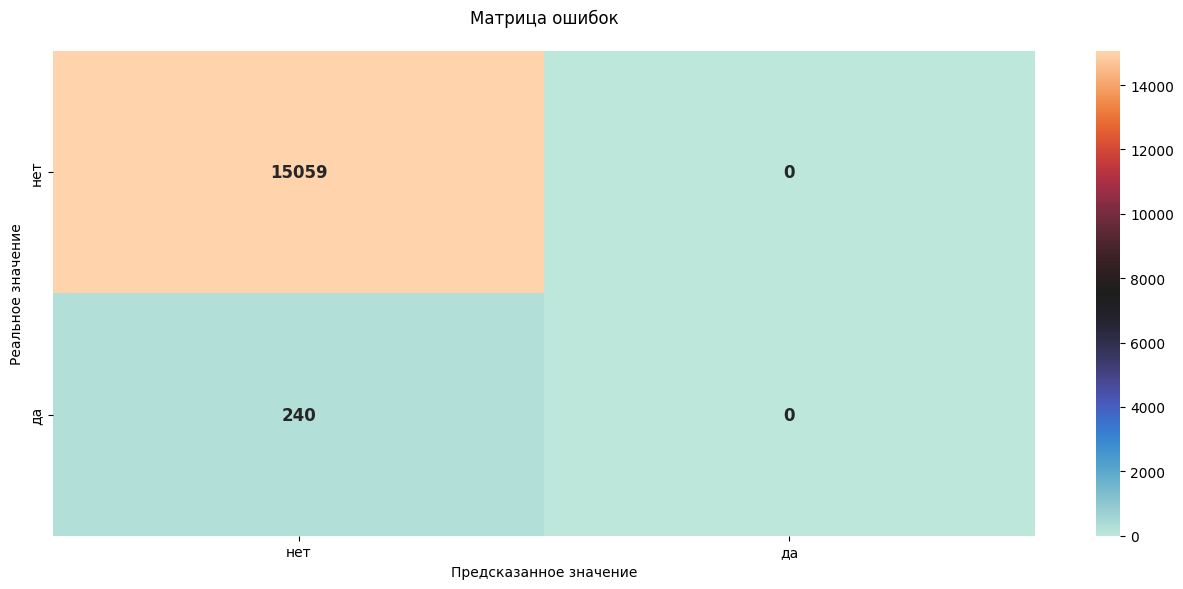

Интерпретация:
  Правильно предсказано 'нет' (True Negative): 15059
  Ложно предсказано 'да' (False Positive): 0
  Ложно предсказано 'нет' (False Negative): 240
  Правильно предсказано 'да' (True Positive): 0


In [234]:
y_pred = best_final_model.predict(X_test)
y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]  # вероятности для положительного класса

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print(f"Метрики на тестовой выборке для финальной модели {best_model_metrics['model_name']}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"F2-score: {f2:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# выведем матрицу ошибок
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_confusion_matrix(cm)

**Комментарий**: на валидационных данных метрика получилась даже лучше, чем на CV:
- Accuracy: 0.7740
- Precision: 0.7179
- Recall: 0.5350
- F1-score: 0.6131
- F2-score: 0.5638
- ROC-AUC: 0.8112
- Average Precision: 0.7302

Рассмотрим теперь кривую `precision-recall` и подберем оптимальный порог по умолчанию.

In [ ]:
if hasattr(best_final_model.named_steps['model'], 'predict_proba'):
    y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]
else:
    # для SVC используем decision_function
    y_pred_proba = best_final_model.decision_function(X_test)
    # нормализуем к [0, 1]
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# строим PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# строим график
plt.figure(figsize=(13, 6))
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Кривая precision-recall')
plt.grid(True)
plt.show()

# смотрим варианты порогов
results_r = []
for target_recall in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
    # находим ближайший порог
    idx = np.argmin(np.abs(recall[:-1] - target_recall))
    threshold = thresholds[idx]
    
    # применяем порог
    y_pred_custom = (y_pred_proba > threshold).astype(int)
    
    # cчитаем метрики
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    
    results_r.append({
        'target_recall': target_recall,
        'threshold': threshold,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"Recall {target_recall}: threshold={threshold:.3f}, precision={prec:.3f}, f1={f1:.3f}")


In [ ]:
#  оптимальный порог
optimal_threshold = 0.25

# вероятности на тестовой выборке
y_pred_proba_test = best_final_model.predict_proba(X_test)[:, 1]

# используем порог
y_pred_custom = (y_pred_proba_test > optimal_threshold).astype(int)


print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom):.4f}")
print(f"F1: {f1_score(y_test, y_pred_custom):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred_custom))

**Промежуточный вывод**: на валидационных данных метрика получилась даже лучше, чем на CV. 
Был подобран оптимальный порог классификации $0.25$, который дает метрику:
- Accuracy: 0.7484
- Precision: 0.6211
- Recall: 0.6369
- F1: 0.6289
- ROC-AUC: 0.8112

## <u>Анализ фажности признаков</u>

**Комментарий**: выполним теперь анализ важности признаков

## <u>Итоговый вывод</u>